In [288]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import results

pd.options.mode.chained_assignment = None
sns.set('talk')

In [289]:
# Location of REopt outputs
RESULTS_DIR = 'reopt_results'
# Location of URBANopt run results
RUN_DIR = 'run'

try:
    sim_results = results.Results.from_pickle("simulation_results.pickle")
except FileNotFoundError:
    sim_results = results.Results(RESULTS_DIR, RUN_DIR)


In [290]:
def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # Recipe credited to George Sakkis
    pending = len(iterables)
    nexts = itertools.cycle(iter(it).__next__ for it in iterables)
    while pending:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            pending -= 1
            nexts = itertools.cycle(itertools.islice(nexts, pending))


def newline_halfway(string, lower_limit=40):
    """
    Insert a newline at the first space that occurs after halfway through the string.
    """
    length = len(string)
    if length < lower_limit:
        return string
    
    output = string[0:length // 2]
    for i, char in enumerate(string[length//2:]):
        if char != ' ':
            output += char
        else:
            output += '\n'
            break
    output += string[i + length//2 + 1:]
    return output

In [311]:
timeseries = sim_results.get_electricity_usage_and_occupancy(
    locations=['Miami', 'Fargo', 'Richmond', 'Phoenix'], schedules_types=['stochastic'],
    building_nums=list(range(1, 11)),
    occupant_types=['000', '111', '222', '333'], hvac_setbacks=[5], timesteps_per_hour=2)

In [295]:
CLUSTERS = {
    "000": "mostly home",
    "111": "early regular worker",
    "222": "mostly away",
    "333": "regular worker"
}

URDB_NAMES = {
    "5cafb9ce5457a39d457780e6":
        "San Diego Gas & Electric Co: DR-SES",
    "5cd1e30b5457a3a52a54e9d3":
        "Con Ed NY: SC-1 Residential & Religious Voluntary TOD (Rate III) [Westchester]",
    "5d67f2485457a3ab71c68cdd":
        "Southern California Edison Co: TOU-D-PRIME",
    "5dc49b5f5457a39661f6a951": 
        "Salt River Project: Customer Generation Average Demand Price Plan"

}


def add_season_col(df):
    """
    spring: Mar - May
    summer: Jun - Aug
    fall: Sep - Nov
    winter: Dec - Feb
    """
    df['season'] = (df.index.get_level_values(-1).month%12+ 3) // 3
    df['season'] = df['season'].map({
            1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'
        }
    )
    return df


def compare_energy_profiles_by_season(frame, clusters_names, location,
                                      electricity_col='Electricity:Facility(kWh)',
                                      convert_to_kw=True):
    """
    Plot a bunch of line graphs of home electricity usage overlaid on each other.
    
    Expects multiindex of schedules_type -> occupant_types -> building_num -> datetime
    
    spring: Mar - May
    summer: Jun - Aug
    fall: Sep - Nov
    winter: Dec - Feb
    
    :param frame: Multiindexed DataFrame
    :param dict clusters_names: Map of cluster indices to readable names
    """
    seasons = ('summer', 'winter')
    
    if frame.index.names[0] == 'location':
        frame = frame.loc[location]
    else:
        raise ValueError("Location index should be dropped.")
        
    fig, axs = plt.subplots(len(seasons), 2, sharex=True, sharey=True,
                            figsize=(12, 12), squeeze=False)
    frame = add_season_col(frame.copy())
    unrolled = frame.reset_index([n for n in frame.index.names if n != 'Datetime'])
    unrolled['hour'] = unrolled.index.hour + unrolled.index.minute / 60
    unrolled['cluster'] = unrolled['occupant_types'].map(clusters_names)
    unrolled['units'] = (
        unrolled.index.strftime('%Y-%m-%d') +
        unrolled['occupant_types'] +
        unrolled['building_num'].astype(str)
    )
    unrolled['weekend'] = unrolled.index.dayofweek >= 5
    # Convert vales to kW
    if convert_to_kw:
        steps_per_h = 3600 / (unrolled.index[1] - unrolled.index[0]).total_seconds()
        unrolled[electricity_col] /= steps_per_h
        
    num_buildings = len(unrolled['building_num'].unique())
    
    for i, season in enumerate(seasons):
        for j, isweekend in enumerate((False, True)):
            ax = axs[i][j]
            season_data = unrolled.query(f"season == '{season}' and weekend == {isweekend}")

            estimator = np.mean
            units = None
            alpha = 0.8
            ci = 'sd'

            sns.lineplot(
                data=season_data, x='hour', y=electricity_col, hue='cluster',
                style='hvac_setback', ax=ax, units=units, estimator=estimator, ci=ci,
                alpha=alpha, markers=True, err_style=None)
            weekend_descrip = 'weekend' if isweekend else 'weekday'
            ax.set_title(newline_halfway(f"{season}, {weekend_descrip}"),
                         fontsize=20)
            if j != 1 or i != 0:
                ax.legend().set_visible(False)
    fig.suptitle(f"{location} mean daily energy profile ({num_buildings} buildings)", fontsize=24)
    fig.tight_layout()

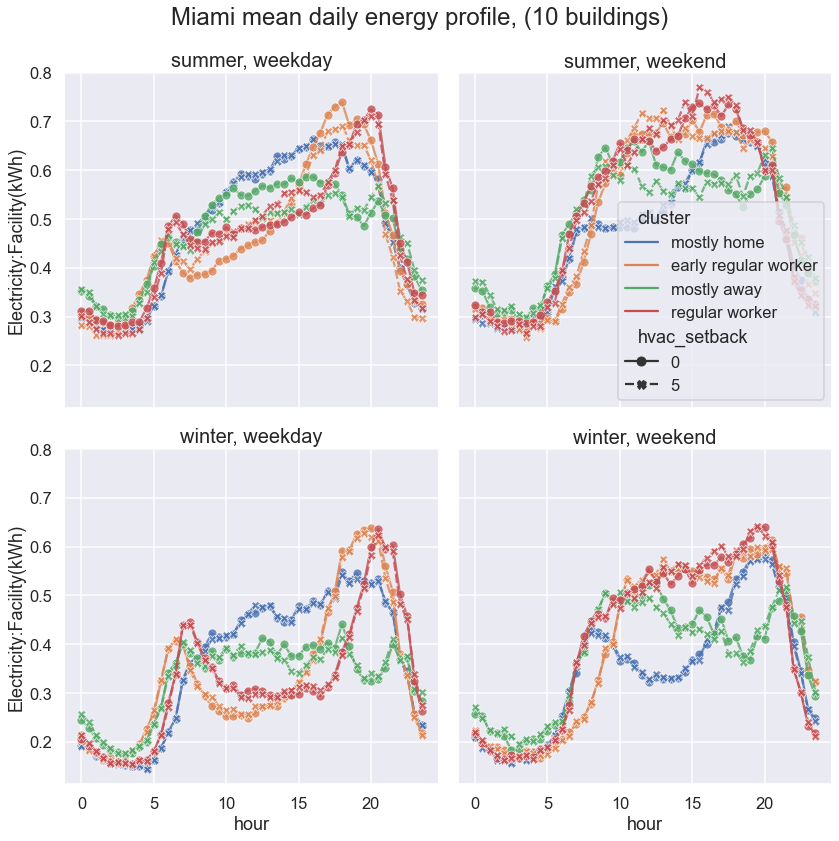

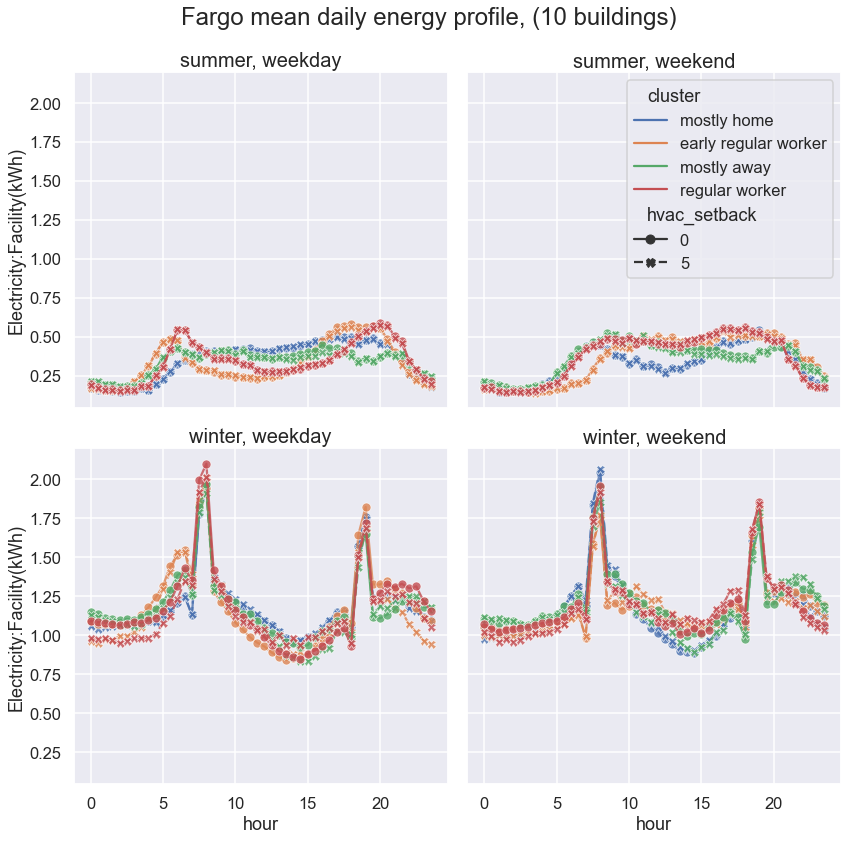

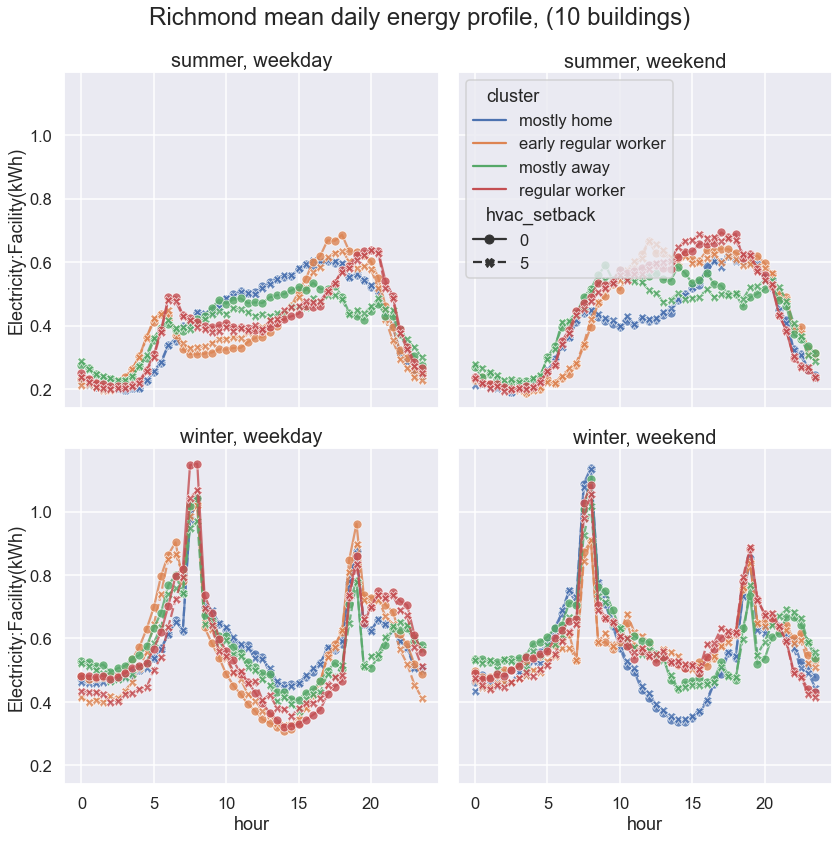

In [192]:
compare_energy_profiles_by_season(timeseries, CLUSTERS, 'Miami')
compare_energy_profiles_by_season(timeseries, CLUSTERS, 'Fargo')
compare_energy_profiles_by_season(timeseries, CLUSTERS, 'Richmond')
# compare_energy_profiles_by_season(timeseries, CLUSTERS, 'Phoenix')

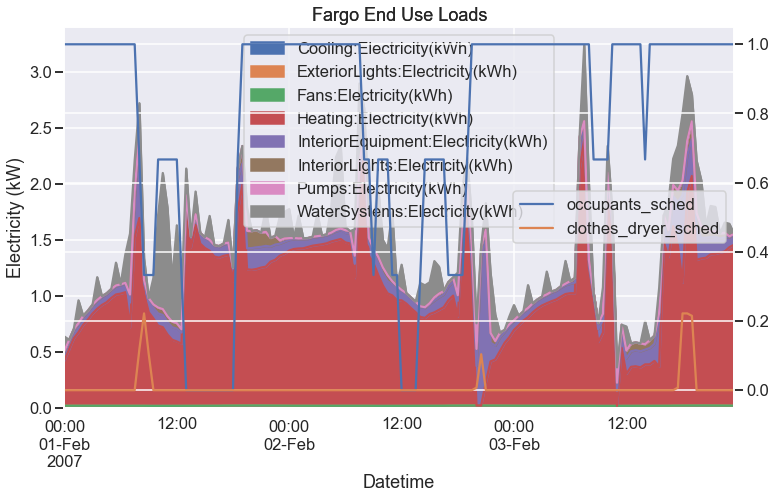

In [349]:
# Plot end use load to determine what the spikes are
fargo_electricity = timeseries.loc[("Fargo", "stochastic", "333", 1, 5)]

end_use_cols = [
    'Cooling:Electricity(kWh)',
    'ExteriorLights:Electricity(kWh)','Fans:Electricity(kWh)',
    'Heating:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
    'InteriorLights:Electricity(kWh)', 'Pumps:Electricity(kWh)',
    'WaterSystems:Electricity(kWh)'
]

(fargo_electricity.loc["2007-02-01 00:00":"2007-02-03 23:59", end_use_cols] / 2).plot.area(
    figsize=(12, 7), title="Fargo End Use Loads")
plt.ylabel("Electricity (kW)")
# plt.legend().remove()
ax = plt.gca()

plt.twinx()
fargo_electricity = timeseries.loc[("Fargo", "stochastic", "333", 1, 5)]
fargo_electricity.loc["2007-02-01 00:00":"2007-02-03 23:59",
                      ['occupants_sched', 'clothes_dryer_sched']].plot(
    figsize=(12, 7), title="Fargo End Use Loads", ax=plt.gca())
plt.legend()

In [339]:
[c for c in timeseries.columns if 'sched' in c]

['baths_sched',
 'ceiling_fan_sched',
 'clothes_dryer_exhaust_sched',
 'clothes_dryer_sched',
 'clothes_washer_power_sched',
 'clothes_washer_sched',
 'cooking_range_sched',
 'dishwasher_power_sched',
 'dishwasher_sched',
 'extra_refrigerator_sched',
 'fixtures_sched',
 'freezer_sched',
 'fuel_loads_fireplace_sched',
 'fuel_loads_grill_sched',
 'fuel_loads_lighting_sched',
 'hot_tub_heater_sched',
 'hot_tub_pump_sched',
 'lighting_exterior_holiday_sched',
 'lighting_exterior_sched',
 'lighting_garage_sched',
 'lighting_interior_sched',
 'occupants_sched',
 'plug_loads_other_sched',
 'plug_loads_tv_sched',
 'plug_loads_vehicle_sched',
 'plug_loads_well_pump_sched',
 'pool_heater_sched',
 'pool_pump_sched',
 'refrigerator_sched',
 'showers_sched',
 'sinks_sched',
 'sleep_sched',
 'vacancy_sched']

Text(0, 0.5, 'Electricity (kW)')

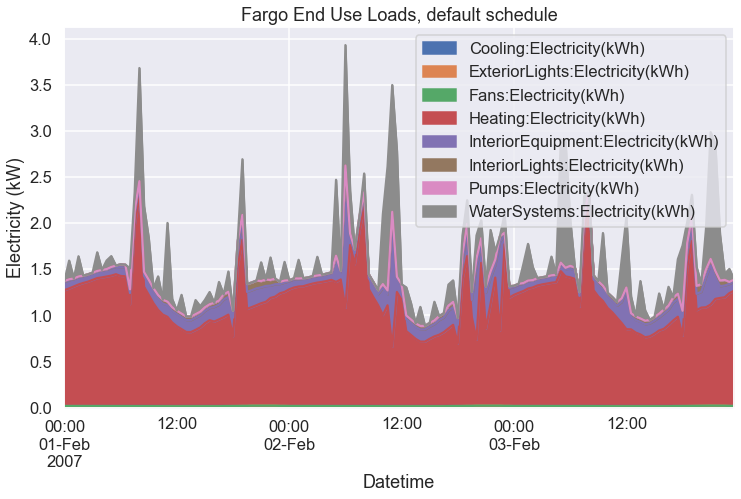

In [318]:
timeseries_default = sim_results.get_scenario_electricity_usage(
    location='Fargo', schedules_type='default',
    building_num=1, occupant_types=None, hvac_setback=0, timesteps_per_hour=2)
end_use_cols = [
    'Cooling:Electricity(kWh)',
    'ExteriorLights:Electricity(kWh)','Fans:Electricity(kWh)',
    'Heating:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
    'InteriorLights:Electricity(kWh)', 'Pumps:Electricity(kWh)',
    'WaterSystems:Electricity(kWh)'
]

(timeseries_default.loc["2007-02-01 00:00":"2007-02-03 23:59", end_use_cols] / 2).plot.area(
    figsize=(12, 7), title="Fargo End Use Loads, default schedule")
plt.ylabel("Electricity (kW)")

In [164]:
sim_results.load(scenario_pattern='.*miami.*', reopt_pattern='.*miami.*')
sim_results.load(scenario_pattern='.*fargo.*', reopt_pattern='.*fargo.*')
reopt_results = sim_results.to_dataframe()
reopt_results['rate_name_complete'] = reopt_results['utility'] + ': ' + reopt_results['rate_name']
sim_results.to_pickle("simulation_results.pickle")

loading runs for home-miami-3-bd-2301-sched-stochastic-occ-111-hvac-setback-0-1406814356...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-111-hvac-setback-5-4669530911...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-222-hvac-setback-5-1643876240...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-000-hvac-setback-0-7053119701...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-000-hvac-setback-5-315836256...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-333-hvac-setback-0-1446058749...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-333-hvac-setback-5-4708775304...
loading runs for home-miami-3-bd-2301-sched-stochastic-occ-222-hvac-setback-0-8381159685...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-333-hvac-setback-0-9506466478...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-333-hvac-setback-5-2769183033...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-222-hvac-setback-0-644

In [267]:
def plot_reopt_results(frame, location,
                       columns=['storage_size_kwh', 'storage_size_kw',
                                'pv_size', 'percent_savings_of_bill'],
                       clusters_names=CLUSTERS):
    frame = frame.copy()
    if isinstance(frame.index, pd.MultiIndex):
        frame.reset_index(inplace=True)

    frame['occupant_cluster'] = frame['schedules_occupant_types'].map(clusters_names)
        
    rates = frame['rate_name_complete'].unique()
    num_rates = len(rates)
        
    frame['net_metering'] = frame['net_metering_limit'] > 1
    
#     fig, axs = plt.subplots(num_rates, len(columns), sharex=False, sharey=False,
#                         figsize=(len(columns) * 12, num_rates * 7), squeeze=False)
    
    # Plot with net metering
#     for i, rate in enumerate(rates):
#         subset = frame.query(f"rate_name_complete == '{rate}' and net_metering")
#         if len(subset) == 0:
#             print("No data for", rate)
#             continue
#         for j, column in enumerate(columns):
#             ax = axs[i][j]
#             sns.lineplot(
#                 data=subset, x='storage_rebate', y=column, hue='occupant_cluster',
#                 style='hvac_setback', ax=ax, alpha=1, ci='sd', markers=True,
#                 err_style="bars")
#             ax.set_xlabel("storage rebate, $/kWh")
#             if j == 0:
#                 ax.set_title(subset['rate_name_complete'].unique()[0])
#     plt.suptitle(f"{location}, net metering", fontsize=36, y=0.98)
#     plt.tight_layout()
    
#     fig, axs = plt.subplots(num_rates, len(columns), sharex=True, sharey=False,
#                         figsize=(len(columns) * 12, num_rates * 7), squeeze=False)

#     # Plot without net metering
#     for i, rate in enumerate(rates):
#         subset = frame.query(f"rate_name_complete == '{rate}' and not net_metering")
#         if len(subset) == 0:
#             print("No data for", rate)
#             continue
#         for j, column in enumerate(columns):
#             ax = axs[i][j]
#             sns.lineplot(
#                 data=subset, x='storage_rebate', y=column, hue='occupant_cluster',
#                 style='hvac_setback', ax=ax, alpha=1, ci='sd', markers=True,
#                 err_style="bars")
#             ax.set_xlabel("storage rebate, $/kWh")
#             if j == 0:
#                 ax.set_title(subset['rate_name_complete'].unique()[0])
#     plt.suptitle(f"{location}, no net metering", fontsize=36, y=0.98)
#     plt.tight_layout()
    
    fig, axs = plt.subplots(len(columns), num_rates, sharex=False, sharey='row',
                        figsize=(num_rates* 10, len(columns) * 7), squeeze=False)

    # Plot with and without net metering by using paired coloring
    for i, rate in enumerate(rates):
        subset = frame.query(f"rate_name_complete == '{rate}'")
        if len(subset) == 0:
            print("No data for", rate)
        
        subset["cluster, net metering"] = \
            subset["occupant_cluster"] + ', ' + \
            subset["net_metering"].apply(lambda x: f"with{'out' if not x else ''} net metering")
        hues = subset['cluster, net metering'].unique()
        
        palette = sns.color_palette('Paired')
        palette = palette[:len(hues)]
            
        for j, column in enumerate(columns):
            ax = axs[j][i]
            sns.lineplot(
                data=subset, x='storage_rebate', y=column, hue='cluster, net metering',
                style='hvac_setback', ax=ax, alpha=1, ci='sd', markers=True,
                err_style="bars", palette=palette, err_kws={'capsize': 10}
            )
            ax.set_xlabel("storage rebate, $/kWh", fontsize=30)
            ax.yaxis.label.set_fontsize(30)
            if j == 0:
                ax.set_title(newline_halfway(URDB_NAMES[subset['urdb'].unique()[0]]),
                    fontsize=30)
                
            if i != axs.shape[1] - 1:
                ax.legend().set_visible(False)
    plt.suptitle(f"{location}", fontsize=36, y=0.98)
    plt.tight_layout()
    
    
#     for cluster in clusters_names.values():        
#         fig, axs = plt.subplots(num_rates, len(columns), sharex=True, sharey=False,
#                         figsize=(len(columns) * 12, num_rates * 7), squeeze=False)
#         for i, rate in enumerate(rates):
#             subset = frame.query(f"rate_name_complete == '{rate}' and occupant_cluster == '{cluster}'")
#             if len(subset) == 0:
#                 print("No data for", rate)
#                 continue
#             for j, column in enumerate(columns):
#                 ax = axs[i][j]
#                 sns.lineplot(
#                     data=subset, x='storage_rebate', y=column, hue='hvac_setback',
#                     style='net_metering', ax=ax, alpha=1, ci='sd', markers=True,
#                     err_style="bars", palette=sns.color_palette()[0:2],
#                     style_order=(True, False))
#     #             sns.scatterplot(
#     #                 data=subset, x='storage_rebate', y=column, hue='hvac_setback',
#     #                 style='net_metering', ax=ax, alpha=1, markers=True,
#     #                 palette=sns.color_palette()[0:2])

#                 ax.set_xlabel("storage rebate, $/kWh")
#                 if j == 0:
#                     ax.set_title(subset['rate_name_complete'].unique()[0])
#         plt.suptitle(f"{location}, {cluster}", fontsize=36, y=0.98)
#         plt.tight_layout()


def plot_reopt_results_stddev(frame, location,
                             columns=['storage_size_kwh', 'storage_size_kw',
                                      'pv_size', 'savings'],
                             grouping_cols=['location', 'urdb', 'schedules_type',
                                            'schedules_occupant_types',
                                            'hvac_setback', 'storage_rebate',
                                            'net_metering_limit'
                                           ],
                             clusters_names=CLUSTERS):
    frame = frame.copy()
    if isinstance(frame.index, pd.MultiIndex):
        frame.reset_index(inplace=True)
    
    stddev_cols = [c + "_std_rel" for c in columns]
    
    stds = []
    for newcol, oldcol in zip(stddev_cols, columns):
        stds.append(frame.groupby(grouping_cols + ['rate_name_complete'])
                     .apply(lambda x: 0 if x[oldcol].mean() == 0 else x[oldcol].std() / x[oldcol].mean())
                     .reset_index(name=newcol))
    frame_std = pd.concat(stds, axis=1)
    
    frame_std = frame_std.loc[:, ~frame_std.columns.duplicated()]
    frame_std['occupant_cluster'] = frame_std['schedules_occupant_types'].map(clusters_names)
        
    rates = frame_std['rate_name_complete'].unique()
    num_rates = len(rates)
        
    frame_std['net_metering'] = frame_std['net_metering_limit'] > 1
    
    fig, axs = plt.subplots(len(columns), num_rates, sharex=False, sharey='row',
                        figsize=(num_rates* 8, len(columns) * 7), squeeze=False)
    
    # Plot with and without net metering by using paired coloring
    for i, rate in enumerate(rates):
        subset = frame_std.query(f"rate_name_complete == '{rate}'")
        if len(subset) == 0:
            print("No data for", rate)
        
        subset["cluster, net metering"] = \
            subset["occupant_cluster"] + ', ' + \
            subset["net_metering"].apply(lambda x: f"with{'out' if not x else ''} net metering")
        hues = subset['cluster, net metering'].unique()
        
        palette = sns.color_palette('Paired')
        palette = palette[:len(hues)]
            
        for j, column in enumerate(stddev_cols):
            ax = axs[j][i]
            sns.lineplot(
                data=subset, x='storage_rebate', y=column, hue='cluster, net metering',
                style='hvac_setback', ax=ax, alpha=1, markers=True, palette=palette
            )
            ax.set_xlabel("storage rebate, $/kWh", fontsize=30)
            ax.yaxis.label.set_fontsize(30)
            if i != 0:
                ax.legend().set_visible(False)
            if j == 0:
                ax.set_title(newline_halfway(URDB_NAMES[subset['urdb'].unique()[0]]),
                             fontsize=30)

    plt.suptitle(f"{location}", fontsize=36, y=0.98)
    plt.tight_layout()
    

def plot_inverter_sizing(frame, hue='utility', style='location'):
    frame = frame.copy()
    if isinstance(frame.index, pd.MultiIndex):
        frame.reset_index(inplace=True)
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        data=frame, x='storage_size_kwh', y='storage_size_kw', hue=hue,
        style=style
    )
    
def plot_inverter_hist(frame, hue='utility', style='location'):
    frame = frame.copy()
    if isinstance(frame.index, pd.MultiIndex):
        frame.reset_index(inplace=True)
    plt.figure(figsize=(12, 12))
    frame['battery kWh / inverter kW'] = frame['storage_size_kwh'] / frame['storage_size_kw']
    sns.histplot(
        data=frame, x='battery kWh / inverter kW', hue='utility'
    )

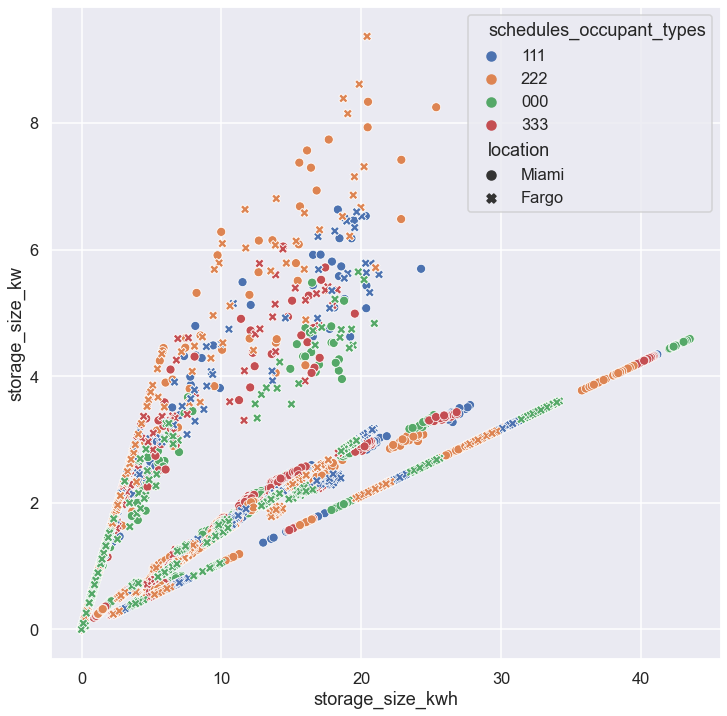

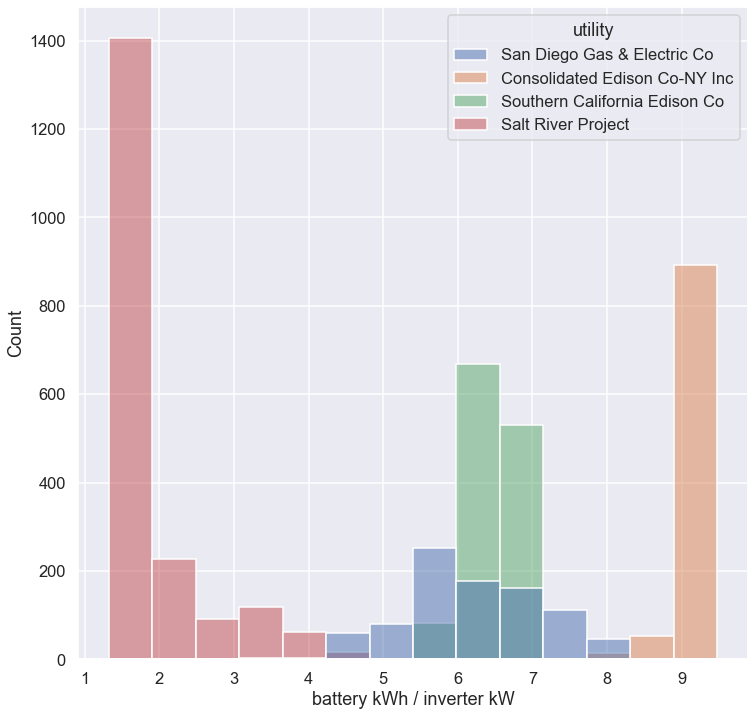

In [201]:
plot_inverter_sizing(reopt_results)
plot_inverter_hist(reopt_results)

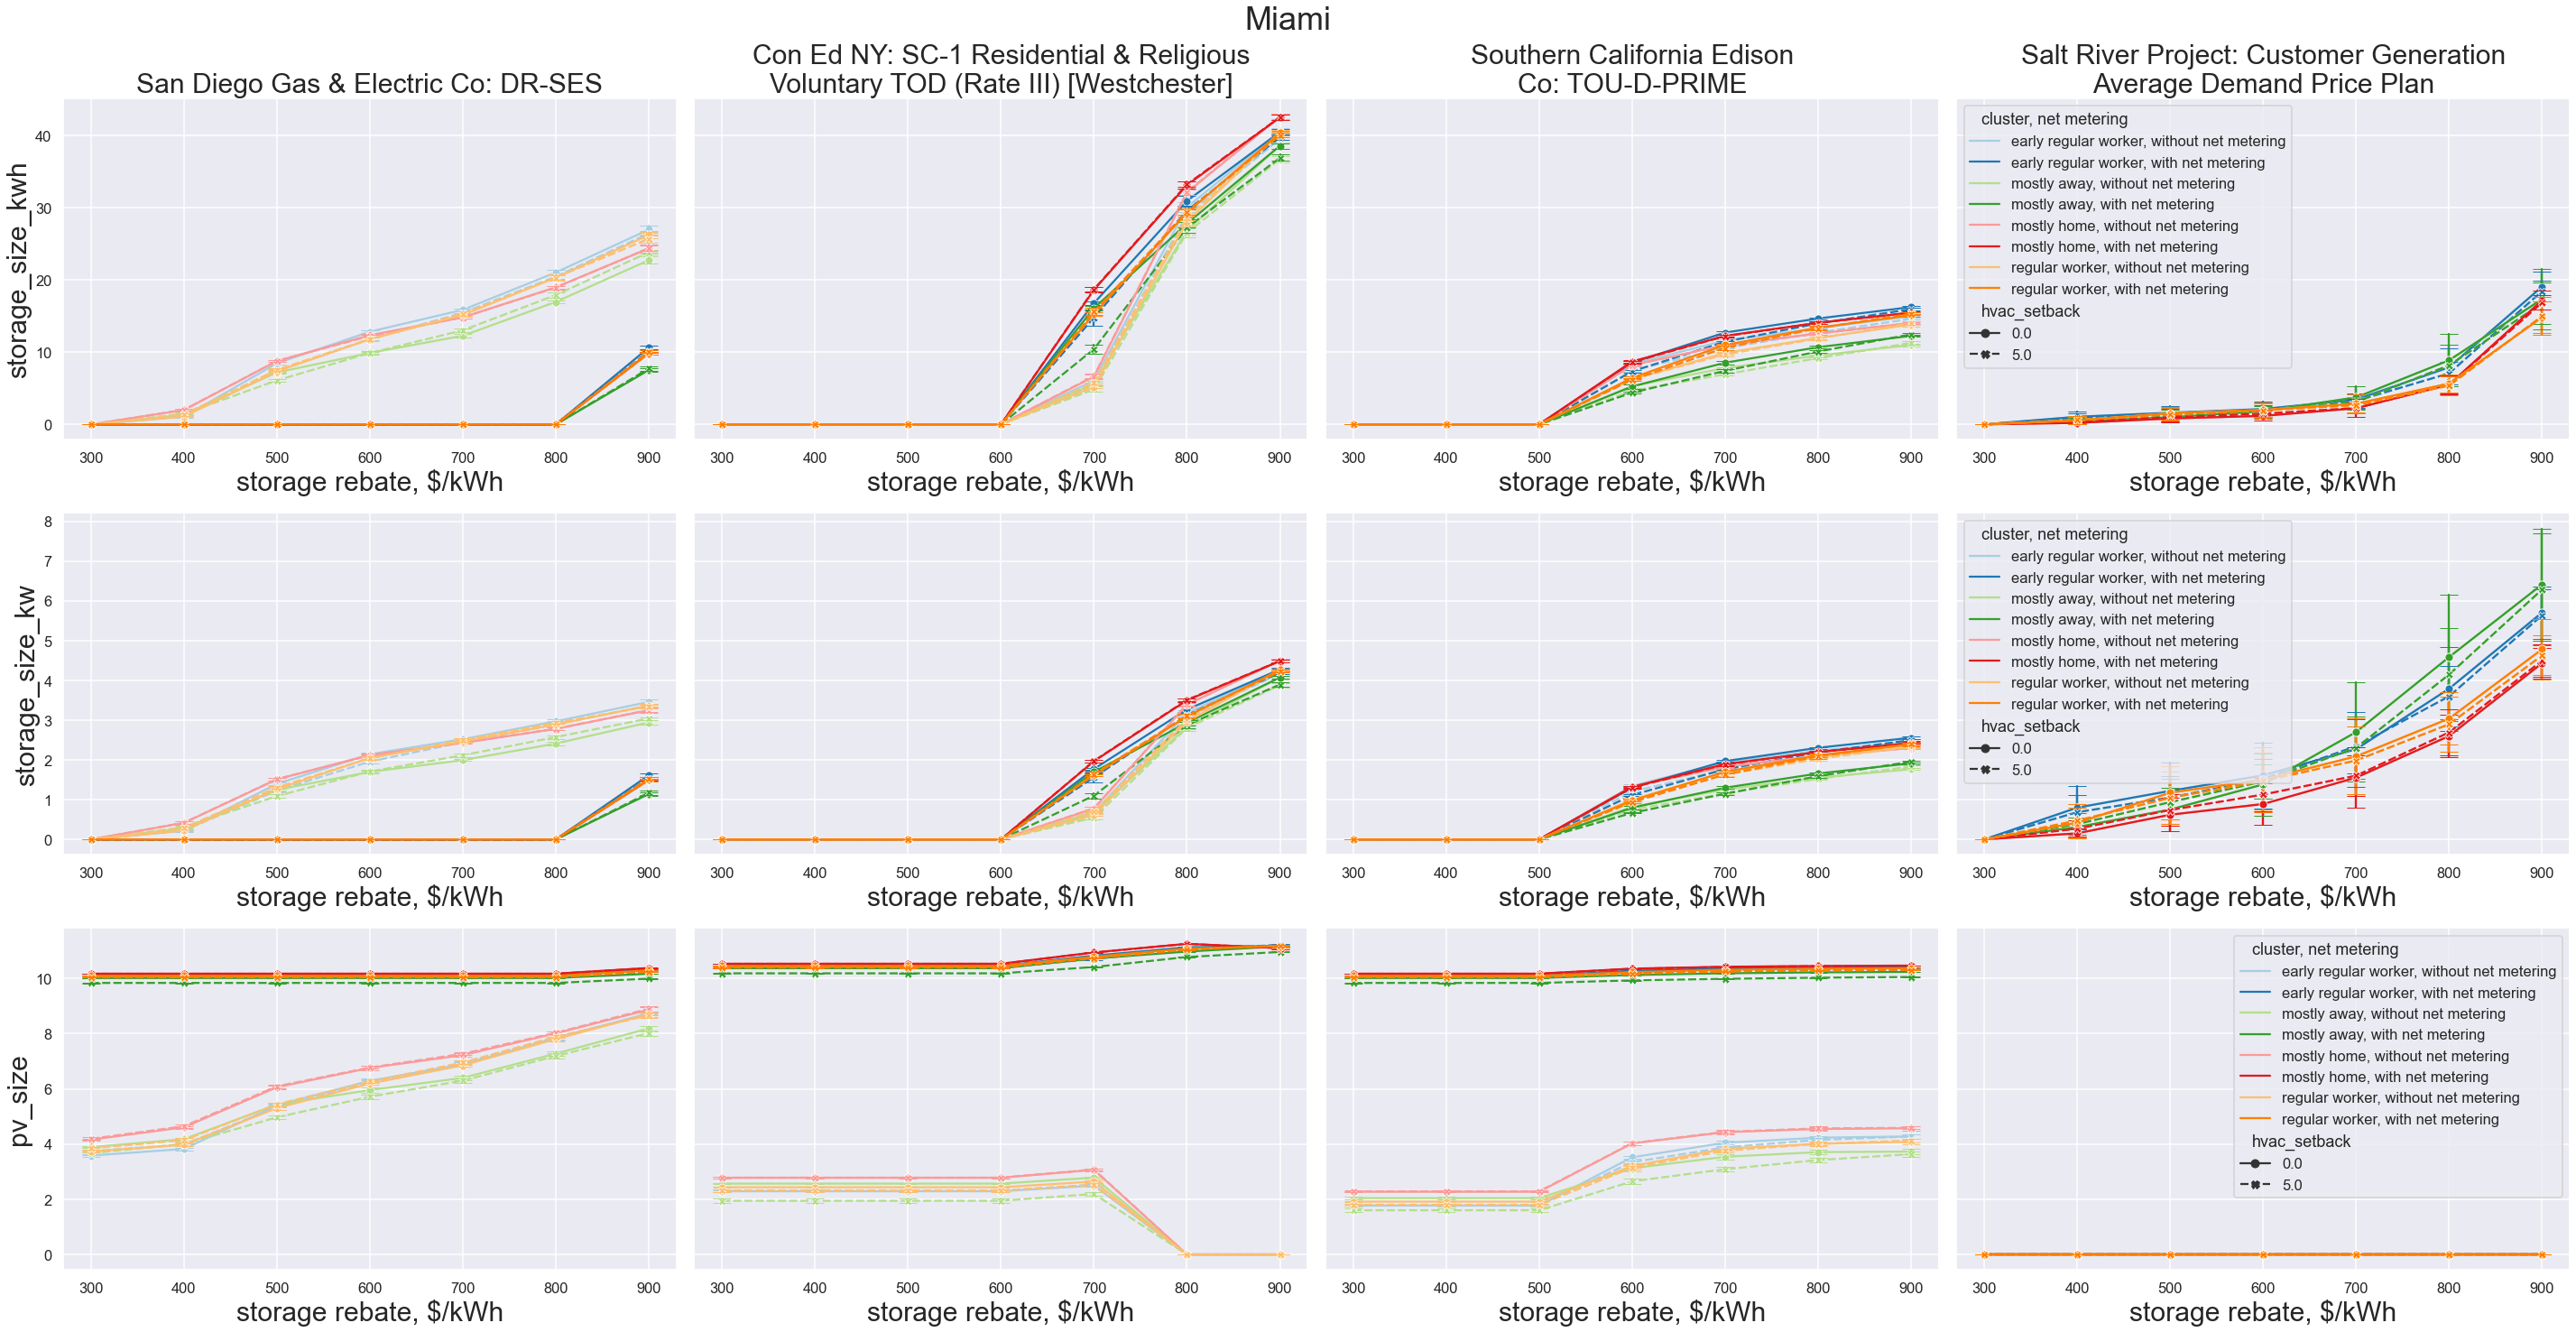

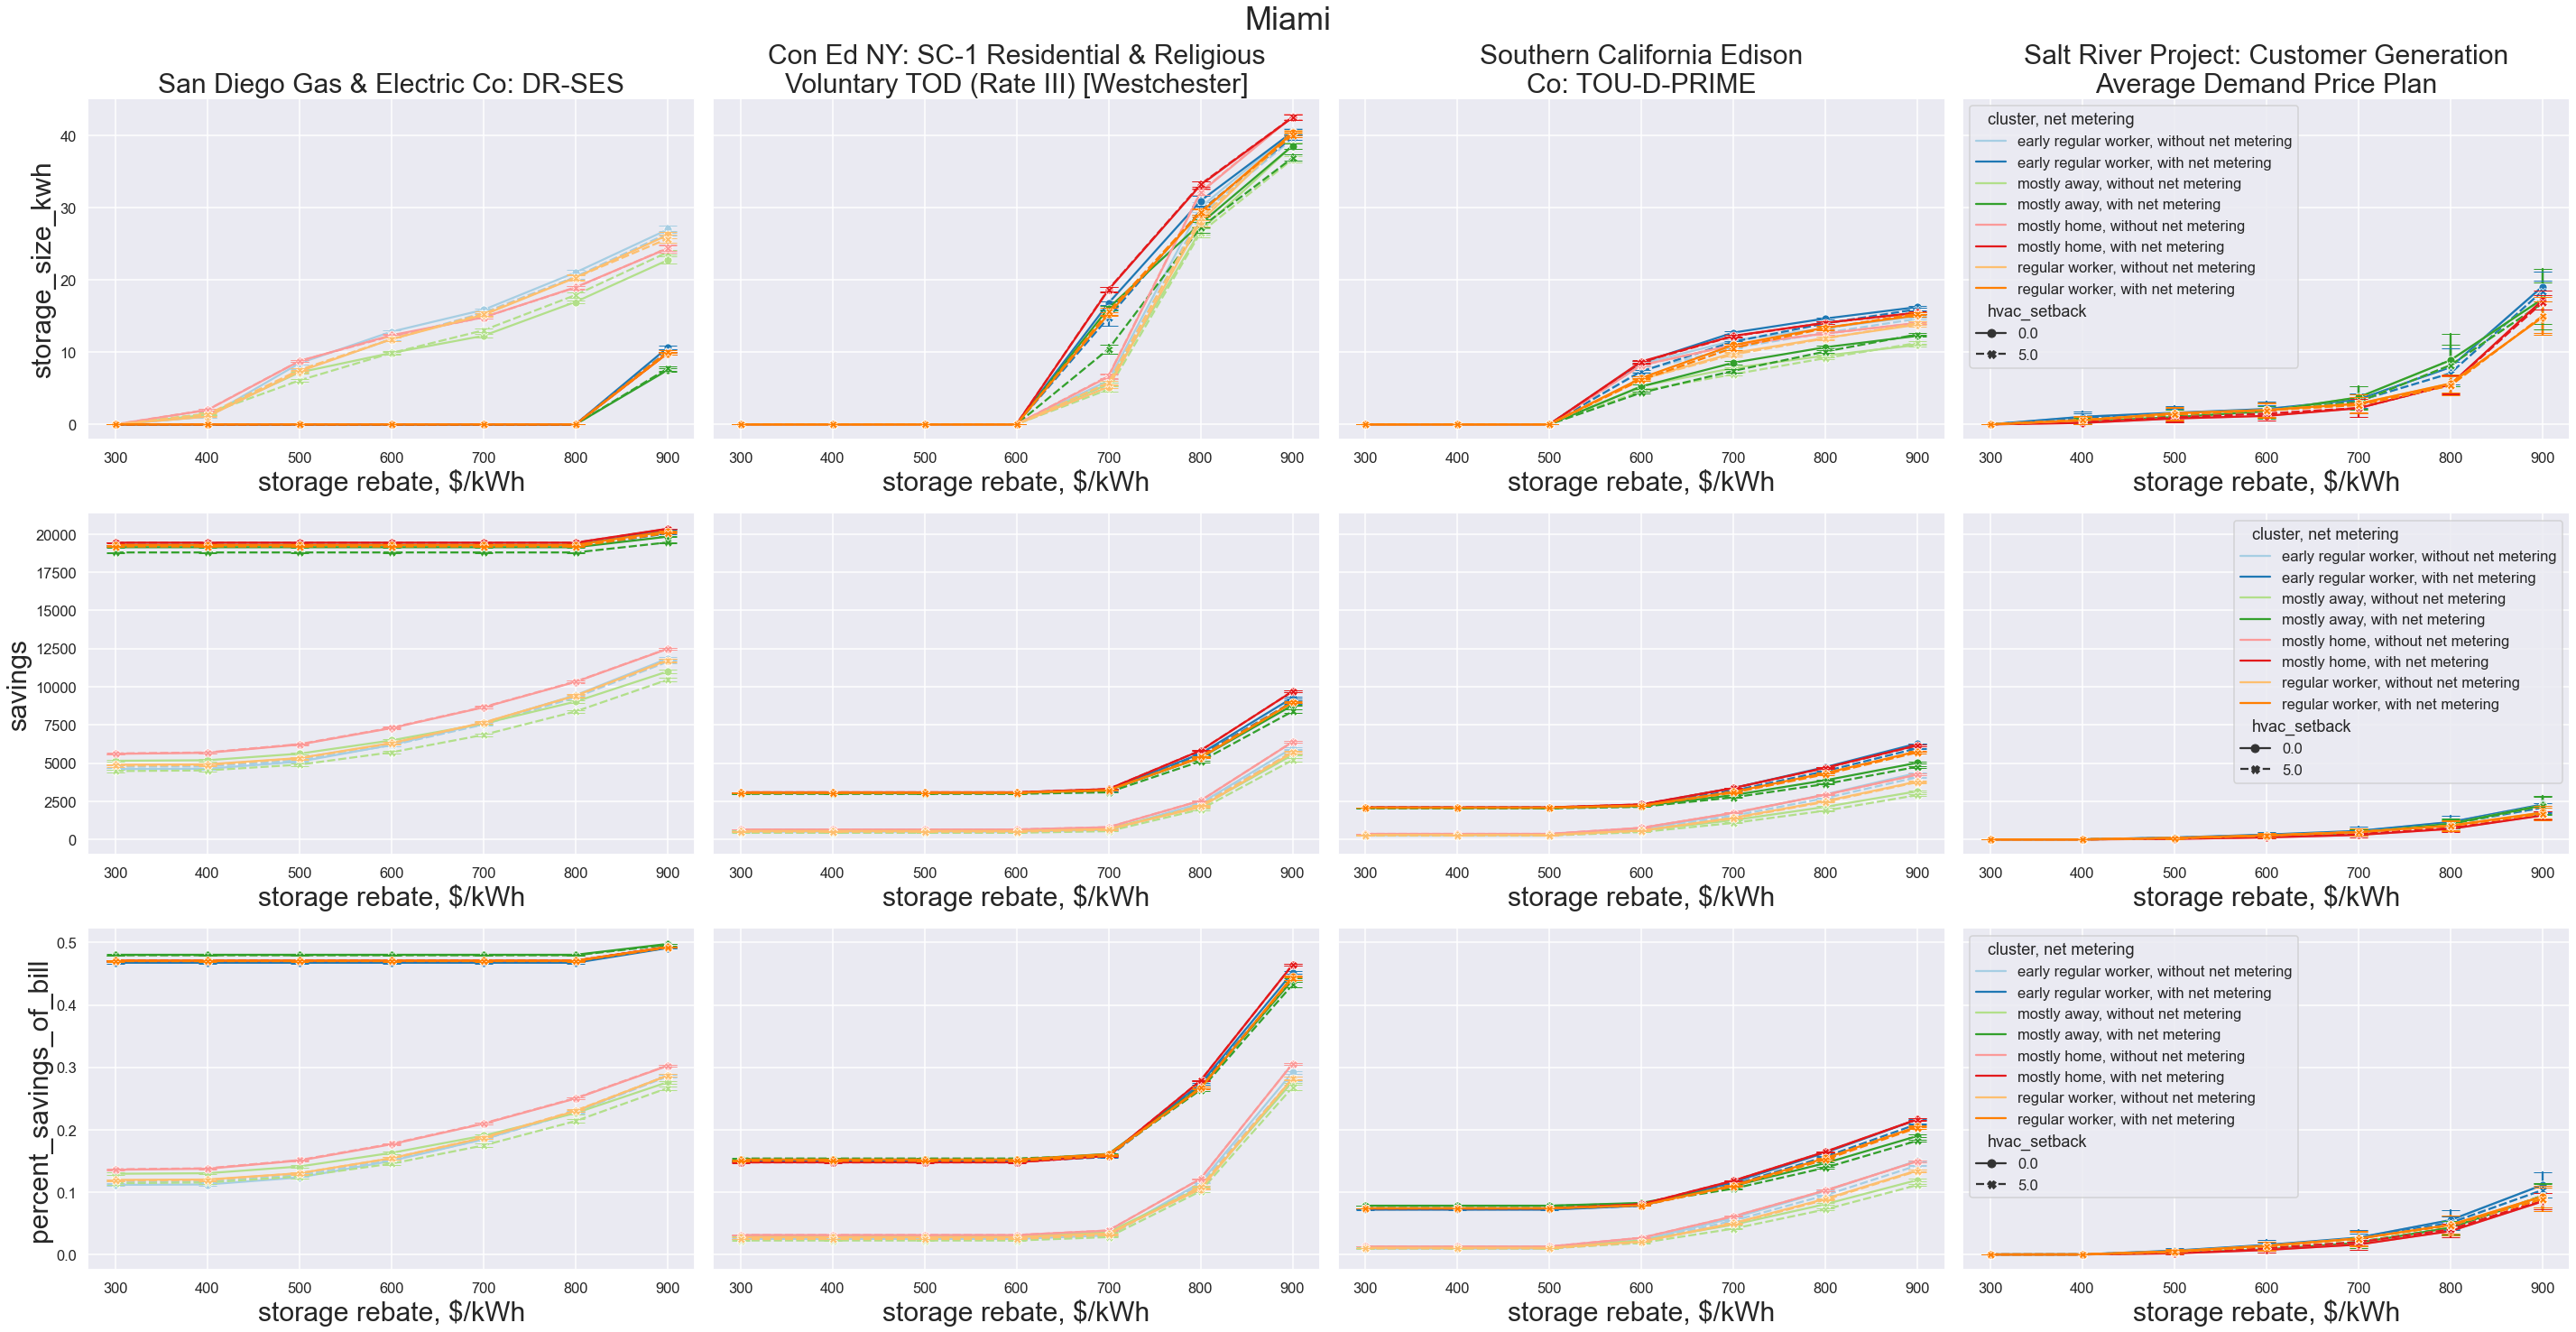

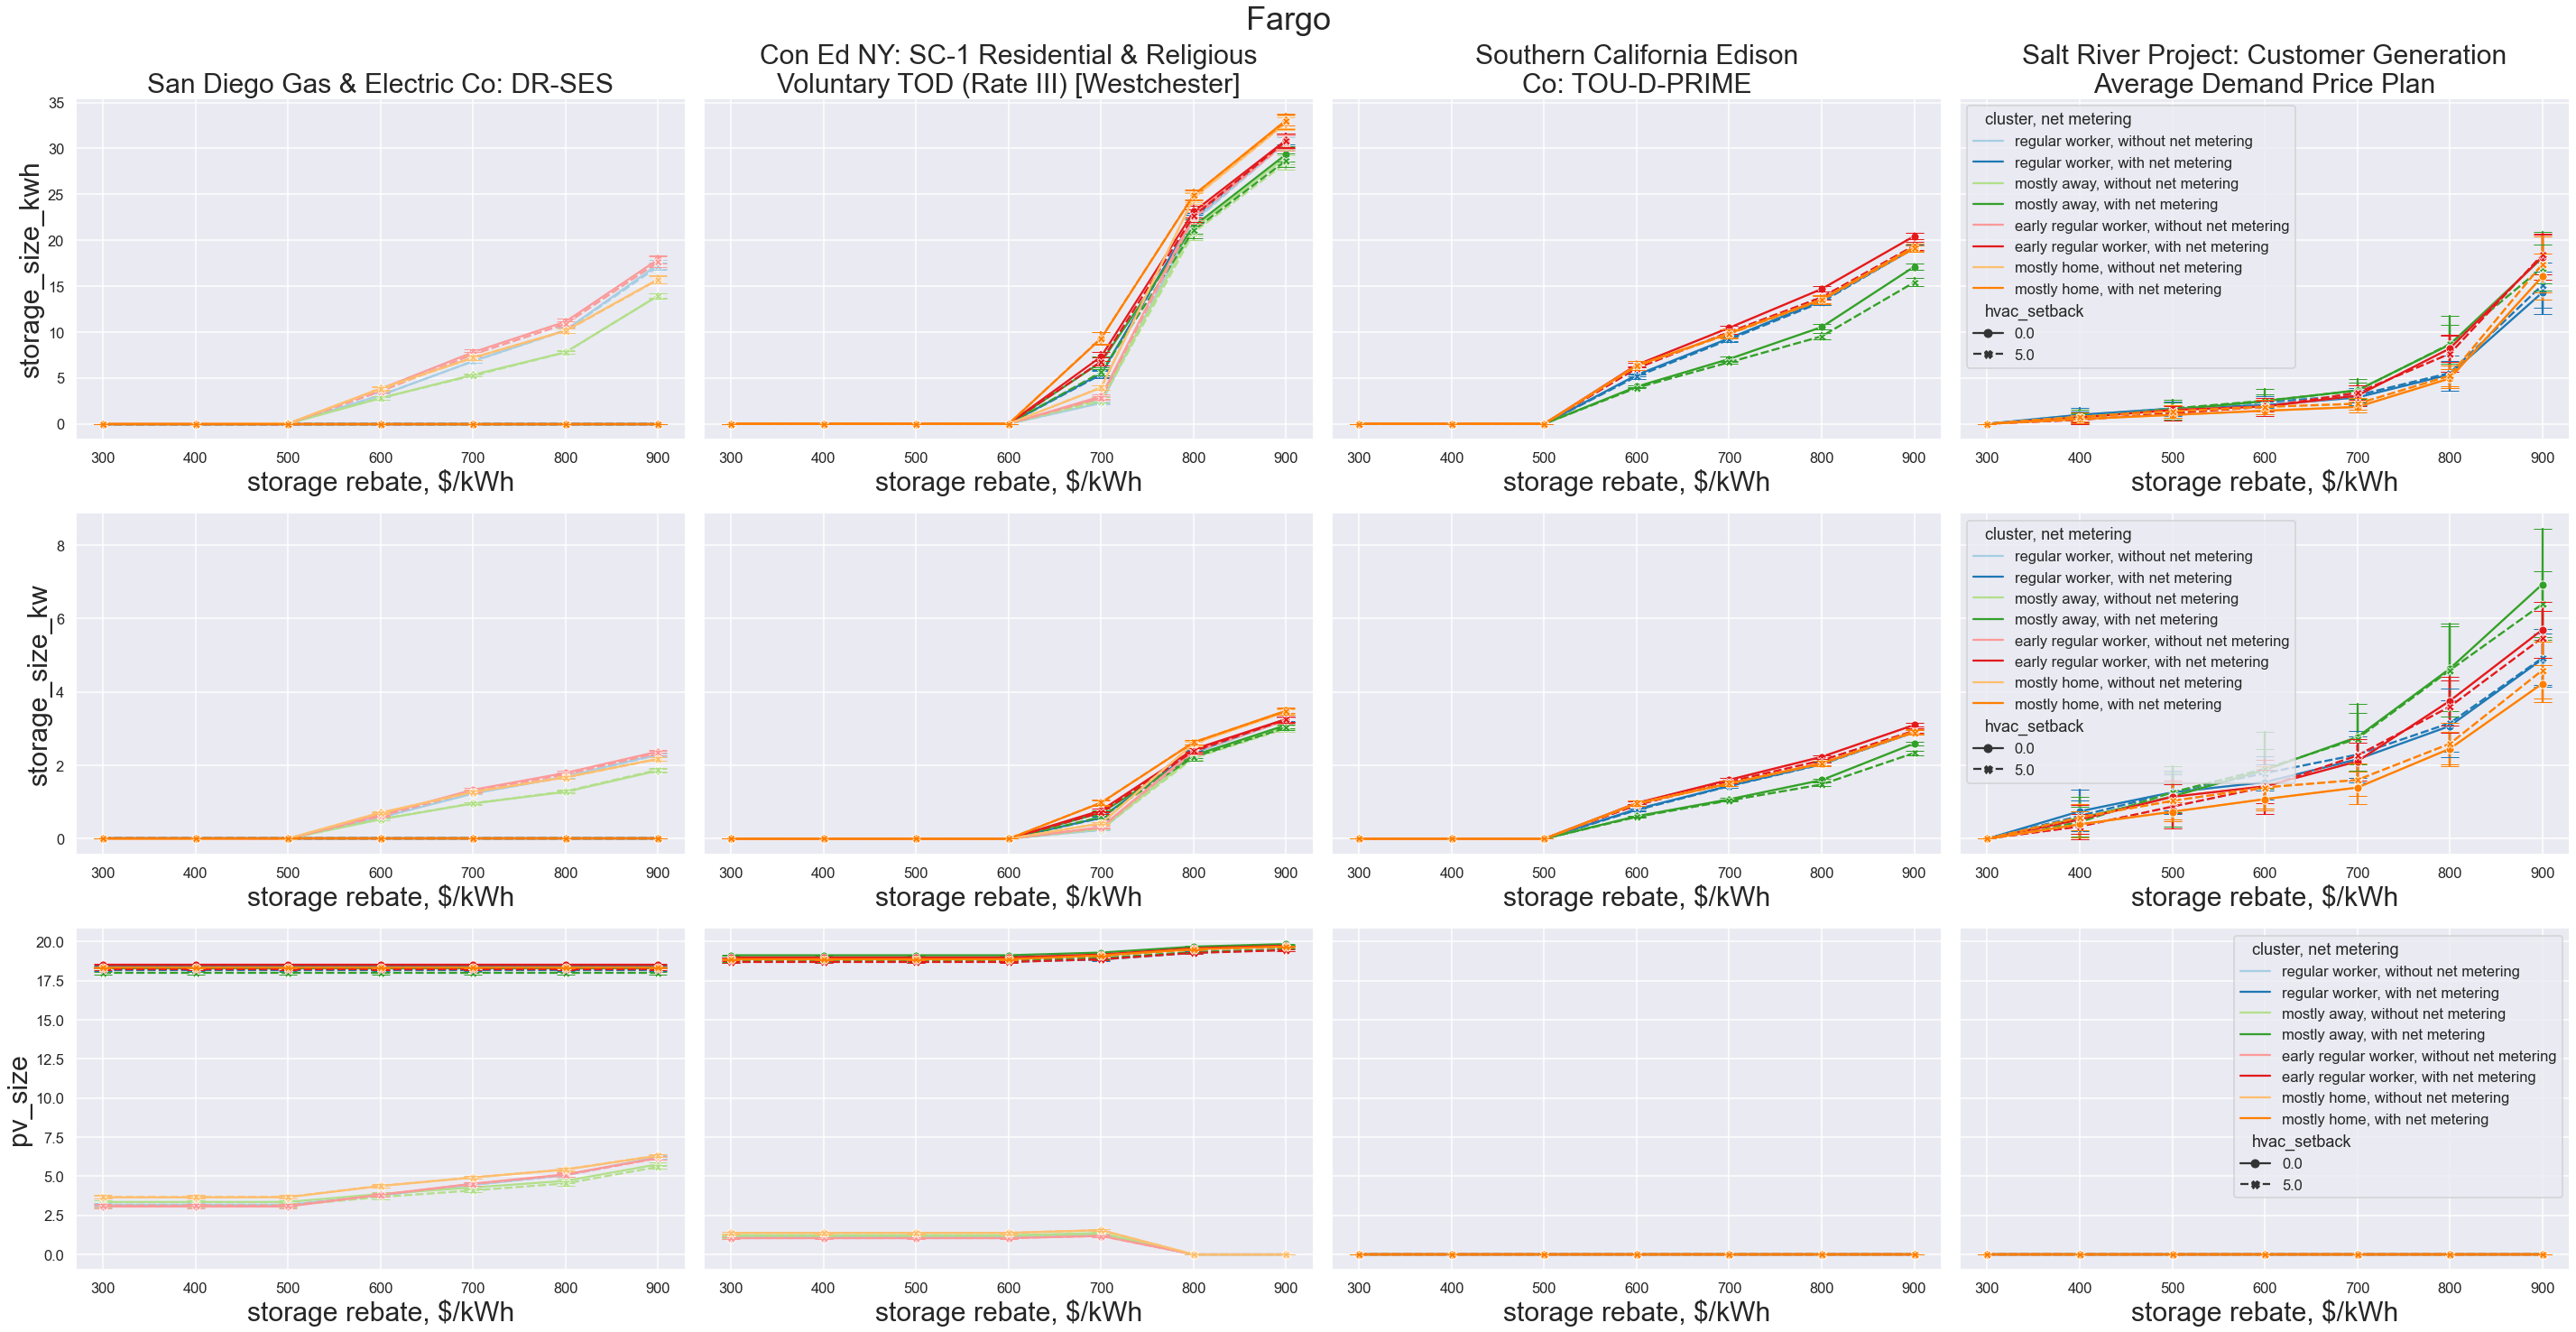

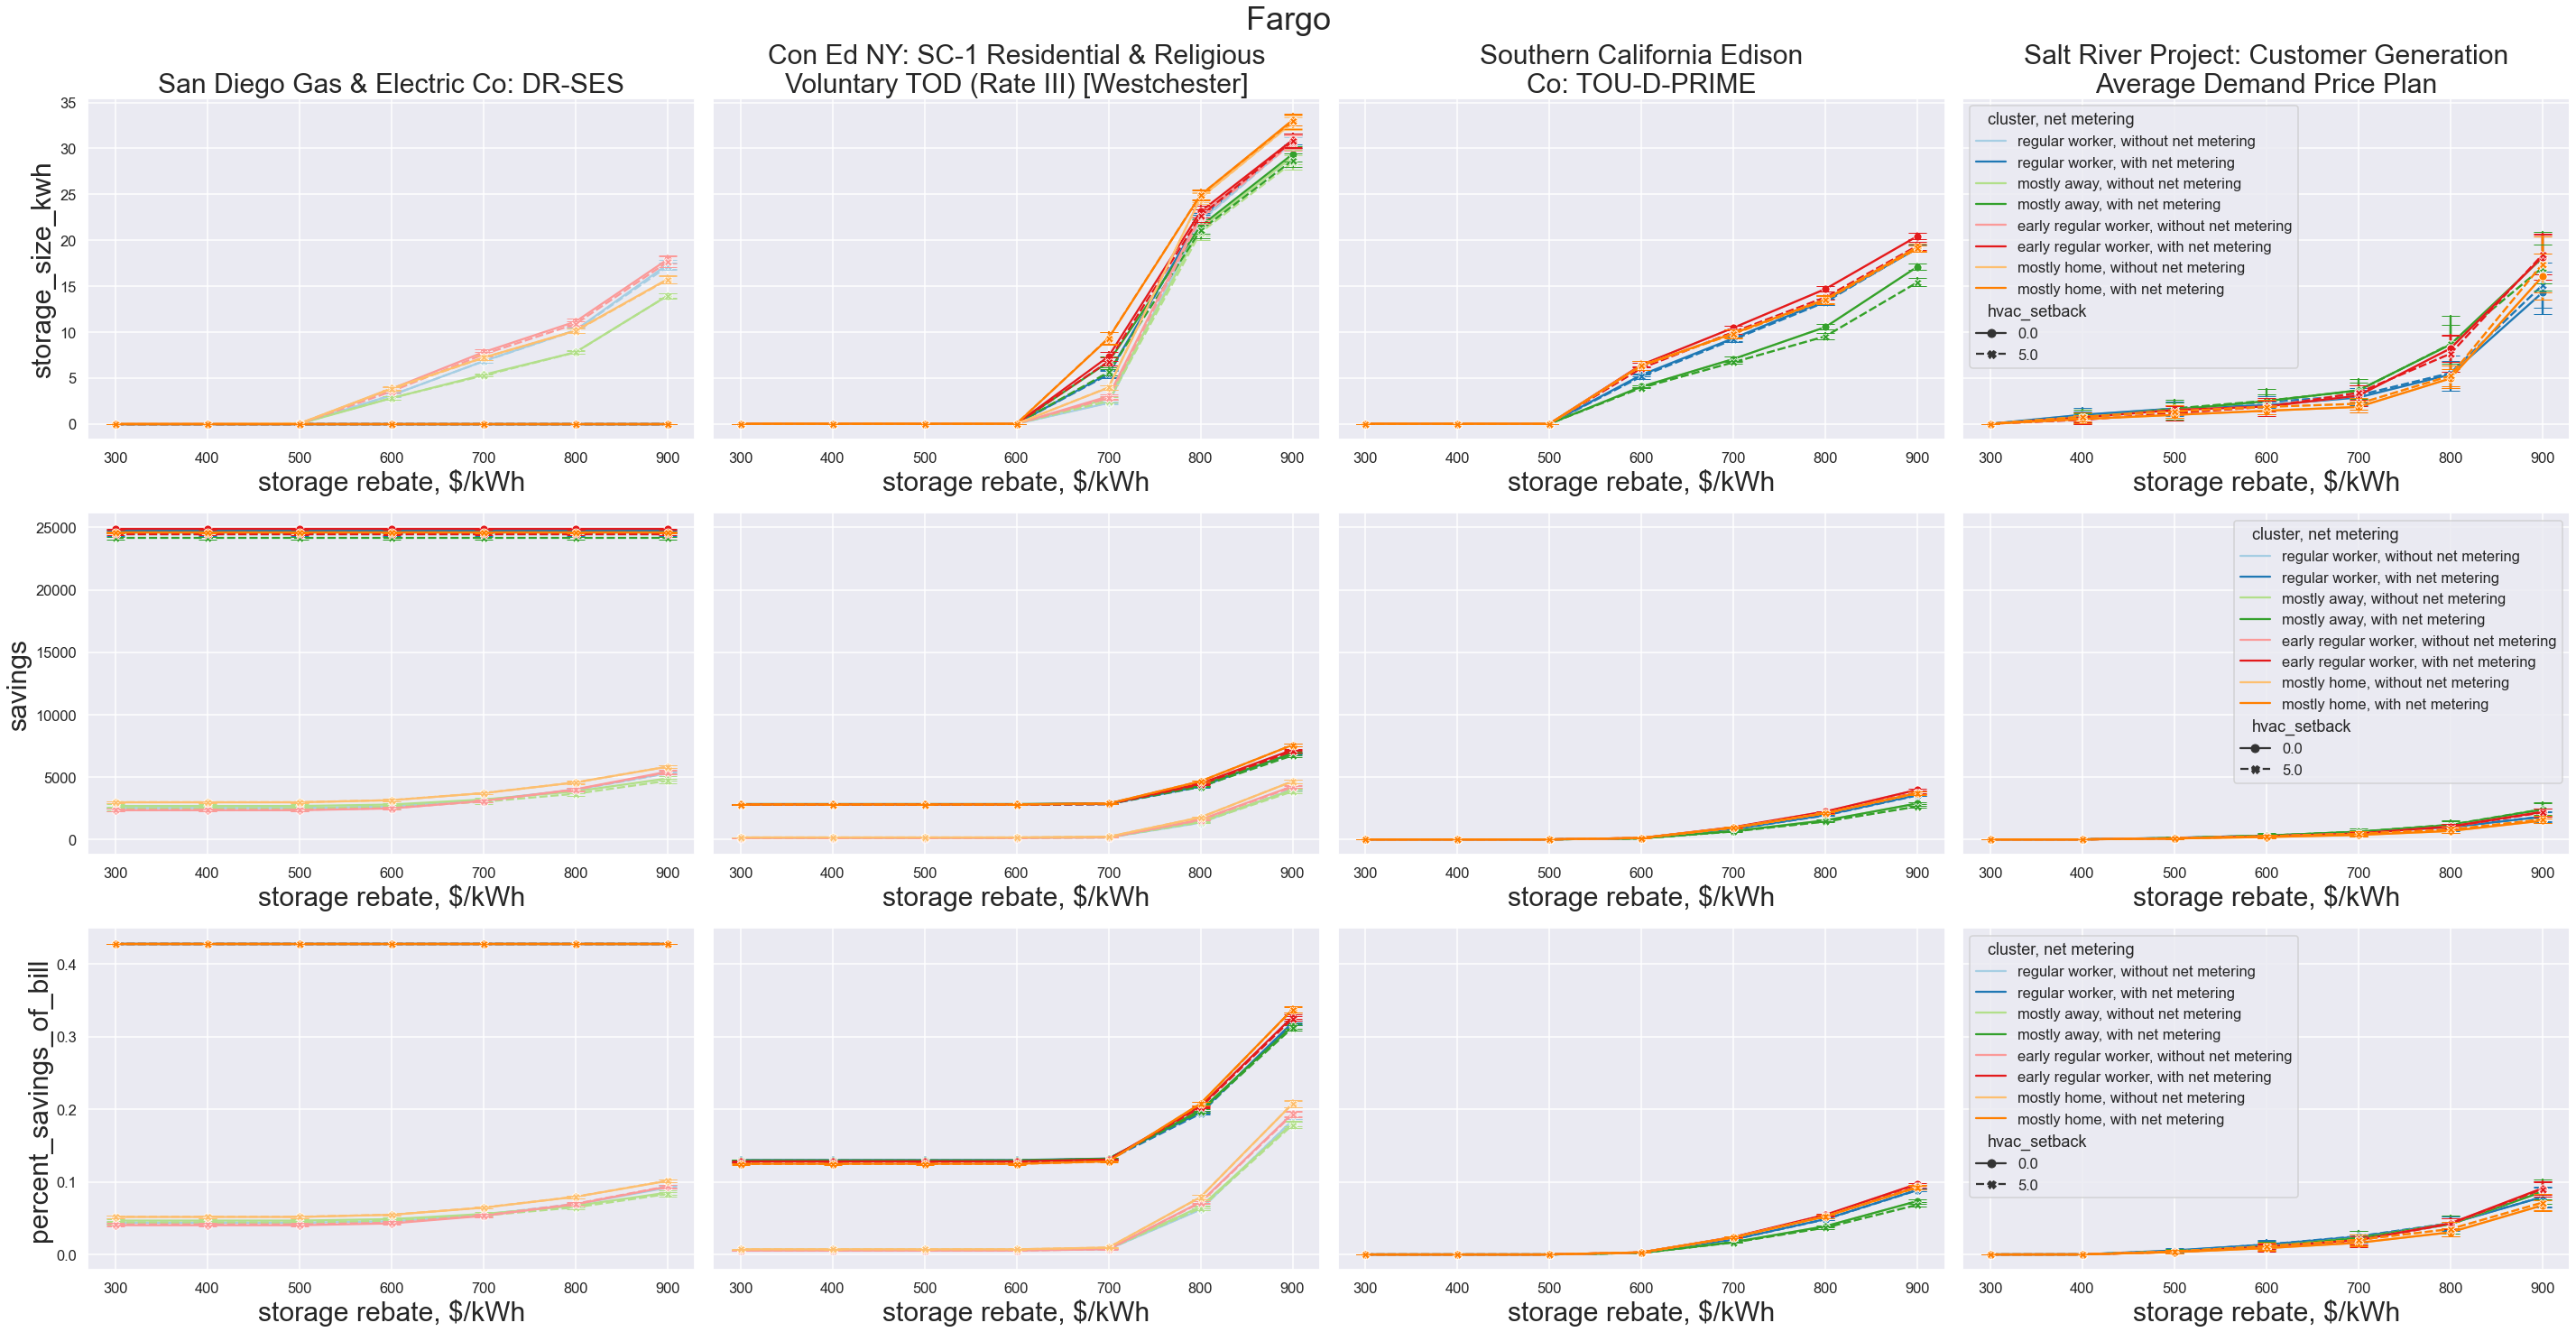

In [233]:
plot_reopt_results(reopt_results.query("location == 'Miami'"), 'Miami', 
                   columns=['storage_size_kwh', 'storage_size_kw', 'pv_size'],
                   clusters_names=CLUSTERS)
plot_reopt_results(reopt_results.query("location == 'Miami'"), 'Miami', 
                   columns=['storage_size_kwh',
                            'savings', 'percent_savings_of_bill'],
                   clusters_names=CLUSTERS)
plot_reopt_results(reopt_results.query("location == 'Fargo'"), 'Fargo', 
                   columns=['storage_size_kwh', 'storage_size_kw', 'pv_size'],
                   clusters_names=CLUSTERS)
plot_reopt_results(reopt_results.query("location == 'Fargo'"), 'Fargo', 
                   columns=['storage_size_kwh',
                            'savings', 'percent_savings_of_bill'],
                   clusters_names=CLUSTERS)

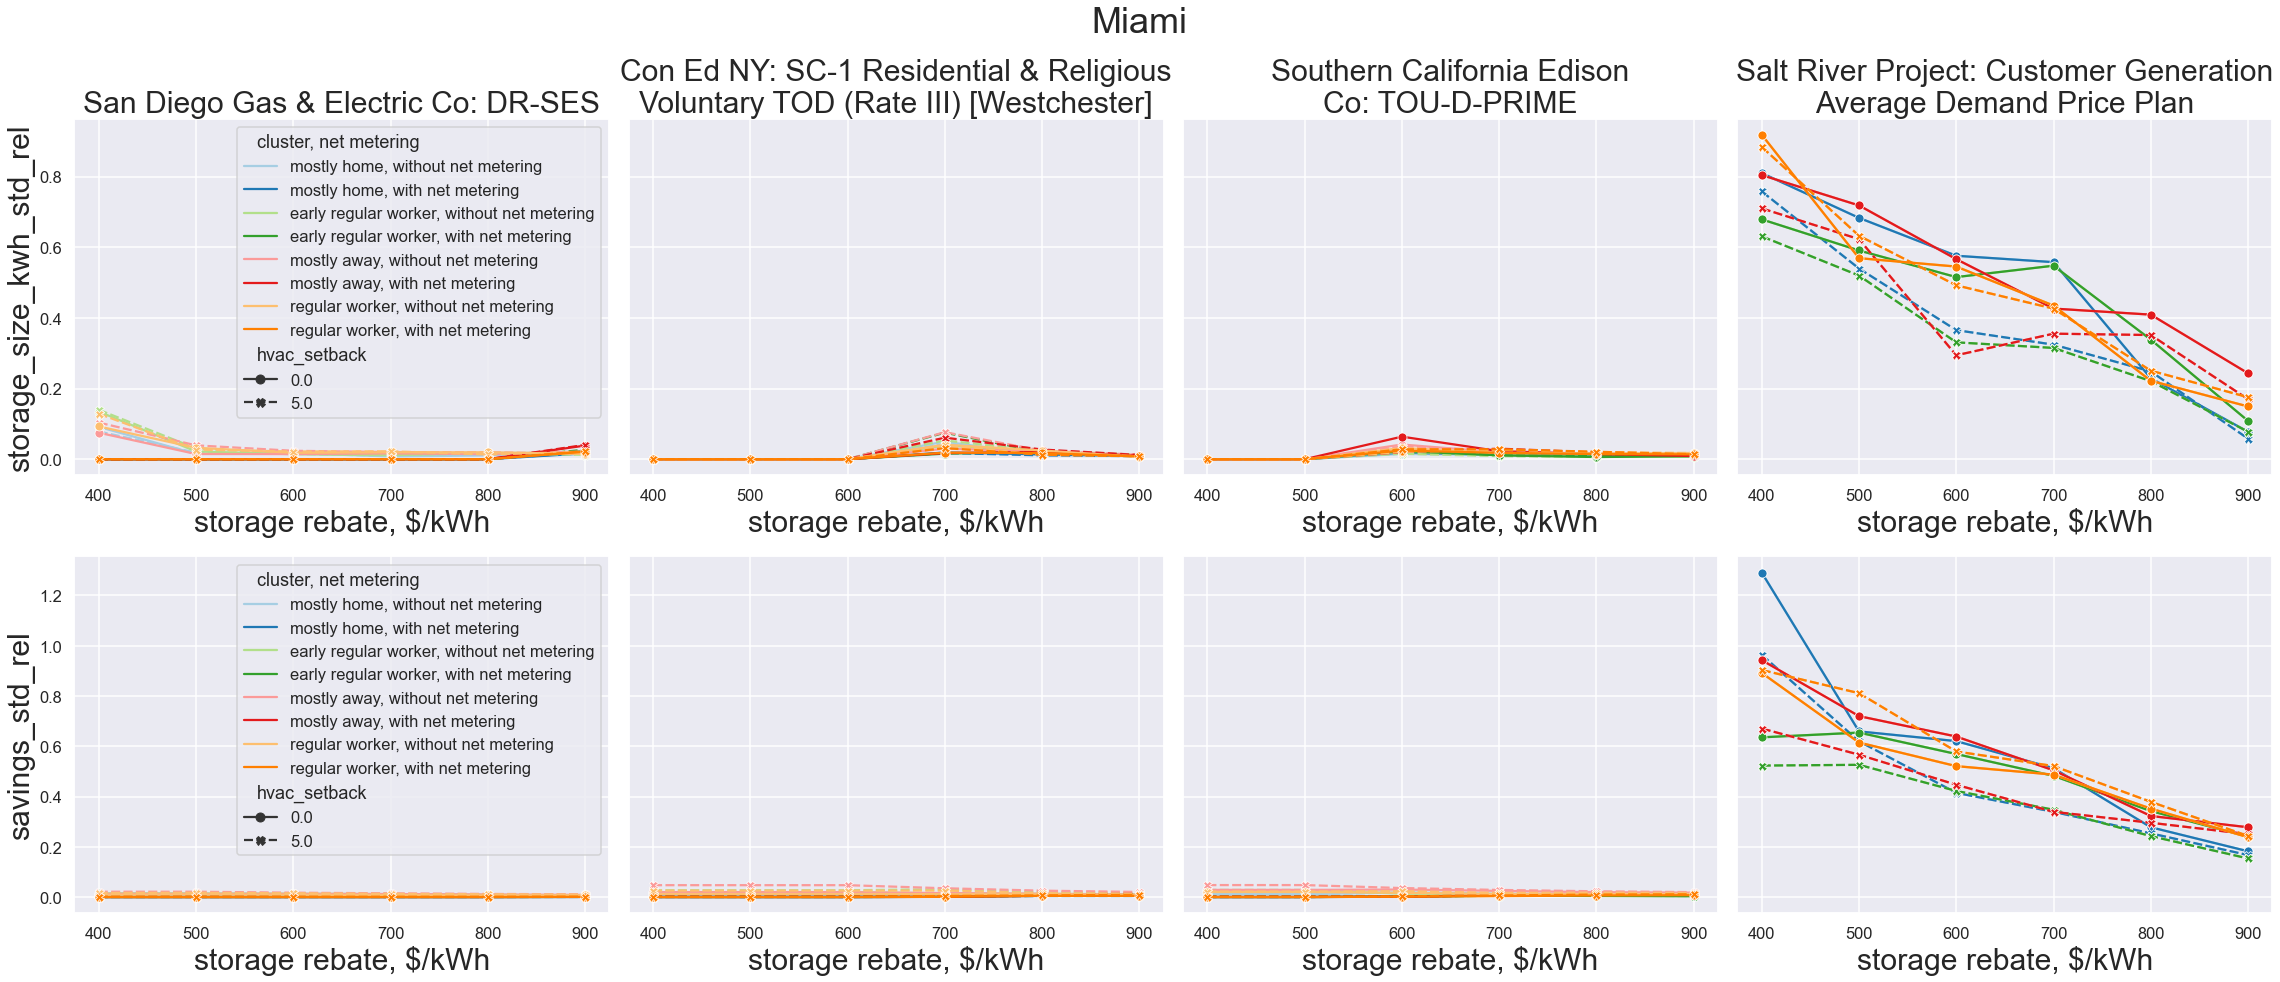

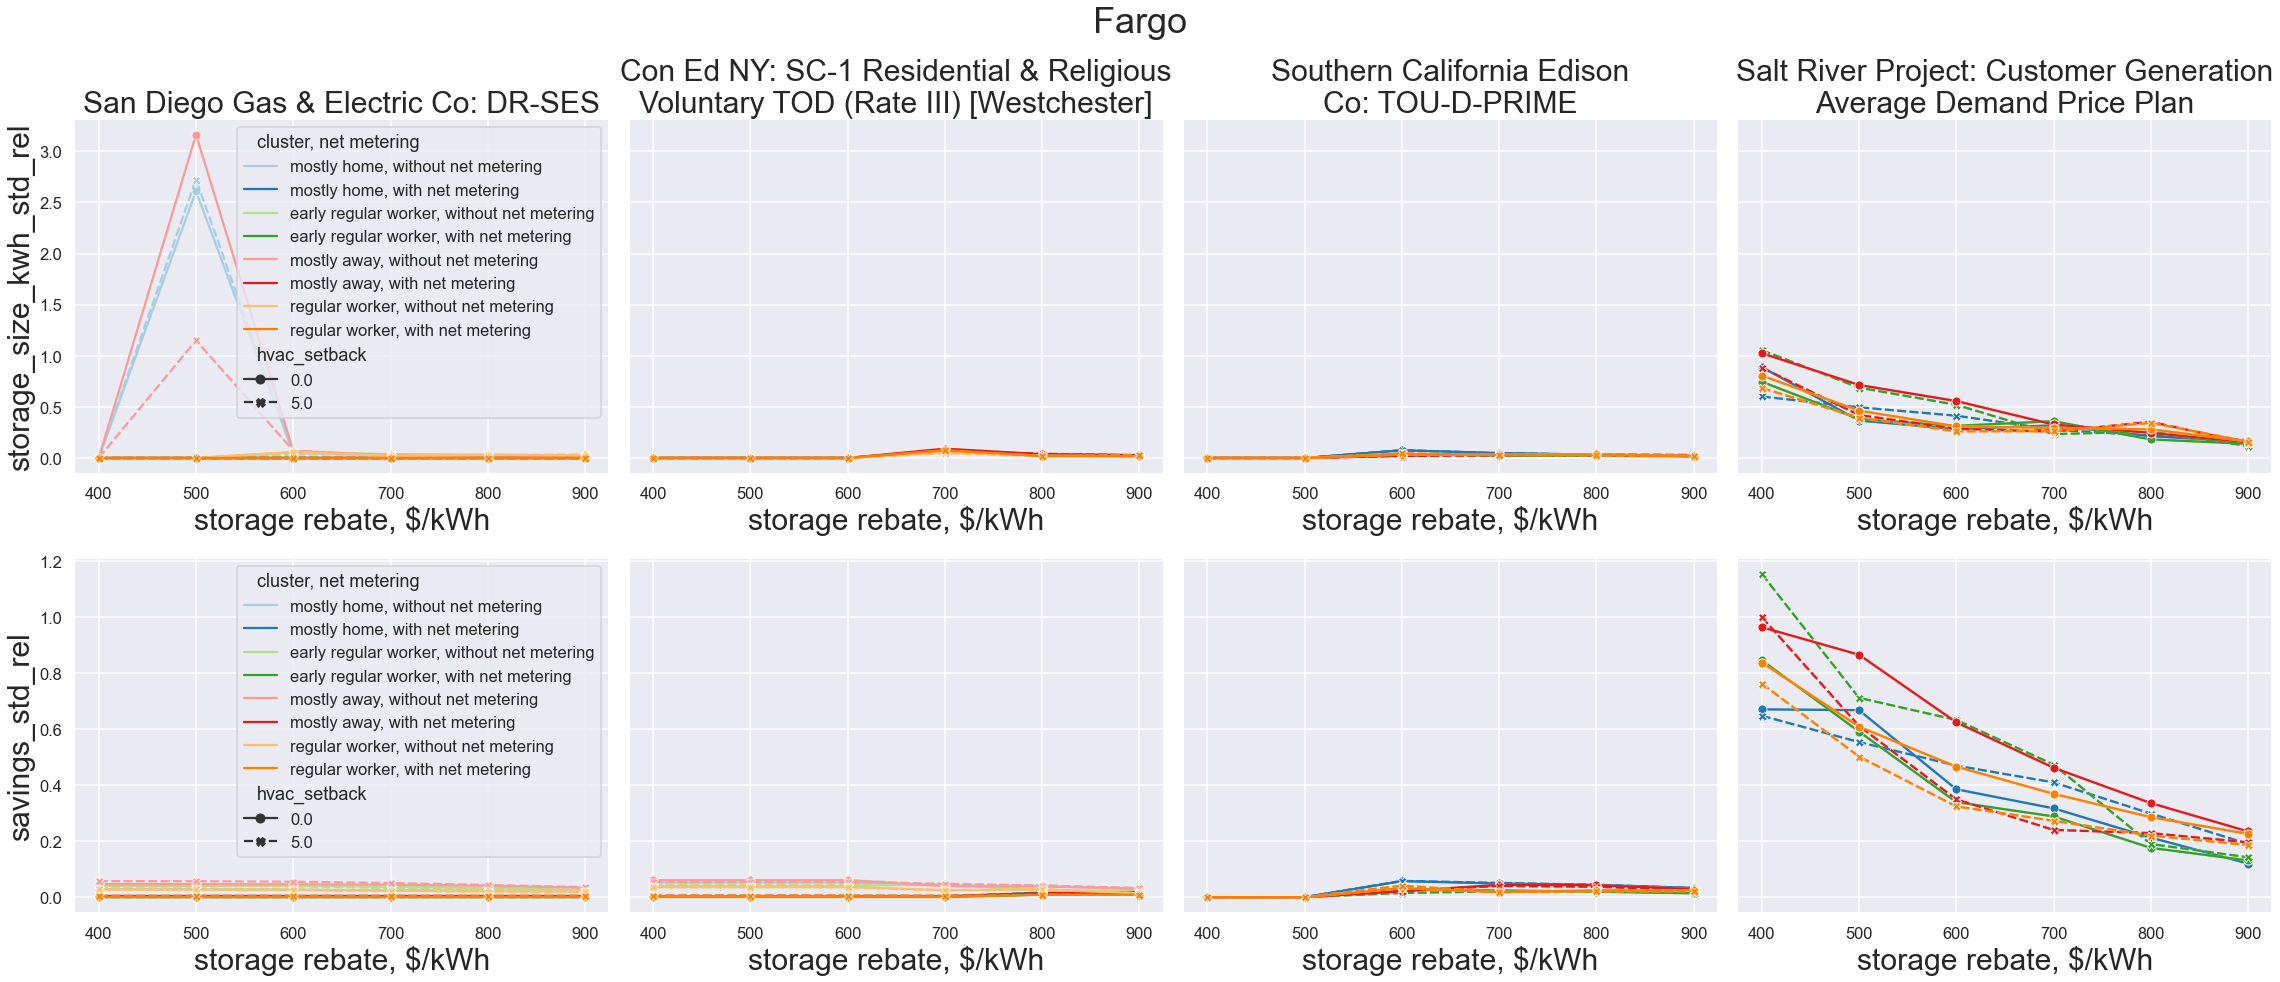

In [268]:
plot_reopt_results_stddev(reopt_results.query("location == 'Miami' and storage_rebate > 300"), 'Miami',
                          columns=["storage_size_kwh", "savings"])
plot_reopt_results_stddev(reopt_results.query("location == 'Fargo' and storage_rebate > 300"), 'Fargo',
                          columns=["storage_size_kwh", "savings"])

In [170]:
reopt_timeseries = sim_results.reopt_timeseries

In [171]:
reopt_timeseries['grid_net_to_house'] = (
    reopt_timeseries['grid_to_load'] + reopt_timeseries['grid_to_battery'] -
    reopt_timeseries['pv_to_grid'] - reopt_timeseries['battery_to_grid']
)

reopt_timeseries['grid_to_house'] = (
    reopt_timeseries['grid_to_load'] + reopt_timeseries['grid_to_battery']
)

In [273]:
def groupby_multiindex(df):
    """
    Group by all but the rightmost index of a multiindexed dataframe.
    """
    level_values = df.index.get_level_values
    return df.groupby([level_values(i) for i in range(df.index.nlevels - 1)])


def compile_load_stats(loads):
    """
    Get load stats that are of interest.
    
    total_pv_power_to_grid --> backfeeding
    
    net_power_from_grid --> sizing of line to house, also get timing
    
    mean_net_power_from_grid --> how much utility gets from costs
    
    total(pv_curtailed) --> pv power lost
    
    """
    maxes = groupby_multiindex(loads).max()
    max_idx = groupby_multiindex(loads).idxmax()
    sums = groupby_multiindex(loads).sum()
    means = groupby_multiindex(loads).mean()
    
    frame = pd.DataFrame(index=maxes.index)
    # Utility demand concerns
    frame['grid_net_to_house_max_kw_bau'] = maxes['load_profile']
    frame['grid_net_to_house_max_kw'] = maxes['grid_net_to_house']
    frame['grid_to_house_max_kw'] = maxes['grid_to_house']
    frame['grid_net_to_house_max_kw_idx'] = max_idx['grid_net_to_house'].map(lambda x: x[-1])
    frame['grid_to_house_max_kw_idx'] = max_idx['grid_to_house'].map(lambda x: x[-1])
    
    frame['grid_net_to_house_mean_kw'] = means['grid_net_to_house']
    frame['grid_net_to_house_mean_kw_bau'] = means['load_profile']
    frame['grid_to_house_mean_kw'] = means['grid_to_house']

    # Backfeeding
    frame['pv_to_grid_total_kwh'] = sums['pv_to_grid']
    frame['pv_to_grid_max_kw'] = maxes['pv_to_grid']
    # ITC and considerations of how to install battery tech
    frame['battery_to_grid_total_kwh'] = sums['battery_to_grid']
    frame['grid_to_battery_total_kwh'] = sums['grid_to_battery']
    frame['pv_to_battery_total_kwh'] = sums['pv_to_battery']
    frame['battery_percent_solar_charged'] = \
        sums['pv_to_battery'] / (sums['pv_to_battery'] + sums['grid_to_battery'])
    
    # curtailment bad
    frame['pv_curtailed_total_kwh'] = sums['pv_curtailed']
    frame['pv_curtailed_fraction'] = sums['pv_curtailed'] / sums['pv_power_production']
    frame['pv_to_grid_fraction'] = sums['pv_to_grid'] / sums['pv_power_production']
    
    return frame


In [274]:
load_stats = compile_load_stats(reopt_timeseries)

In [204]:
# Shows battery doesn't discharge to grid at all for arbitrage!
load_stats['battery_to_grid_total_kwh'].max()

0.0

In [269]:
def plot_load_stats(frame, location,
                    columns=[
                        "grid_net_to_house_max_kw",
                        "grid_net_to_house_mean_kw",
                        "grid_to_house_max_kw",
                        "grid_to_house_mean_kw",
                        "pv_to_grid_total_kwh",
                        "pv_to_grid_max_kw",
                        "battery_percent_solar_charged",
                        "pv_curtailed_total_kwh"
                    ],
                    clusters_names=CLUSTERS, urdb_names=URDB_NAMES):    
    frame = frame.reset_index()
    
    frame['occupant_cluster'] = frame['schedules_occupant_types'].map(clusters_names)
    
    frame['rate_name_complete'] = frame['urdb'].map(urdb_names)
    rates = frame['rate_name_complete'].unique()
    num_rates = len(rates)
        
    frame['net_metering'] = frame['net_metering_limit'] > 1

    # Plot with and without net metering by using paired coloring
    for column in columns:
        fig, axs = plt.subplots(1, num_rates, sharex=False, sharey=True,
                                figsize=(num_rates * 7, 7), squeeze=True)
        for i, rate in enumerate(rates):
            subset = frame.query(f"rate_name_complete == '{rate}'")

            if len(subset) == 0:
                print("No data for", rate)
                continue

            subset["cluster, net metering"] = \
                subset["occupant_cluster"] + ', ' + \
                subset["net_metering"].apply(lambda x: f"with{'out' if not x else ''} net metering")
            hues = subset['cluster, net metering'].unique()

            palette = sns.color_palette('Paired')
            palette = palette[:len(hues)]

            ax = axs[i]
            sns.lineplot(
                data=subset, x='storage_rebate', y=column, hue='cluster, net metering',
                style='hvac_setback', ax=ax, alpha=1, ci='sd', markers=True,
                err_style="bars", palette=palette, err_kws={'capsize': 10}
            )
            ax.set_xlabel("storage rebate, $/kWh")
            ax.set_title(newline_halfway(subset['rate_name_complete'].unique()[0]))

            if i != len(rates) - 1:
                ax.legend().set_visible(False)
            else:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.suptitle(f"{location}", fontsize=36, y=0.98)
        plt.tight_layout()

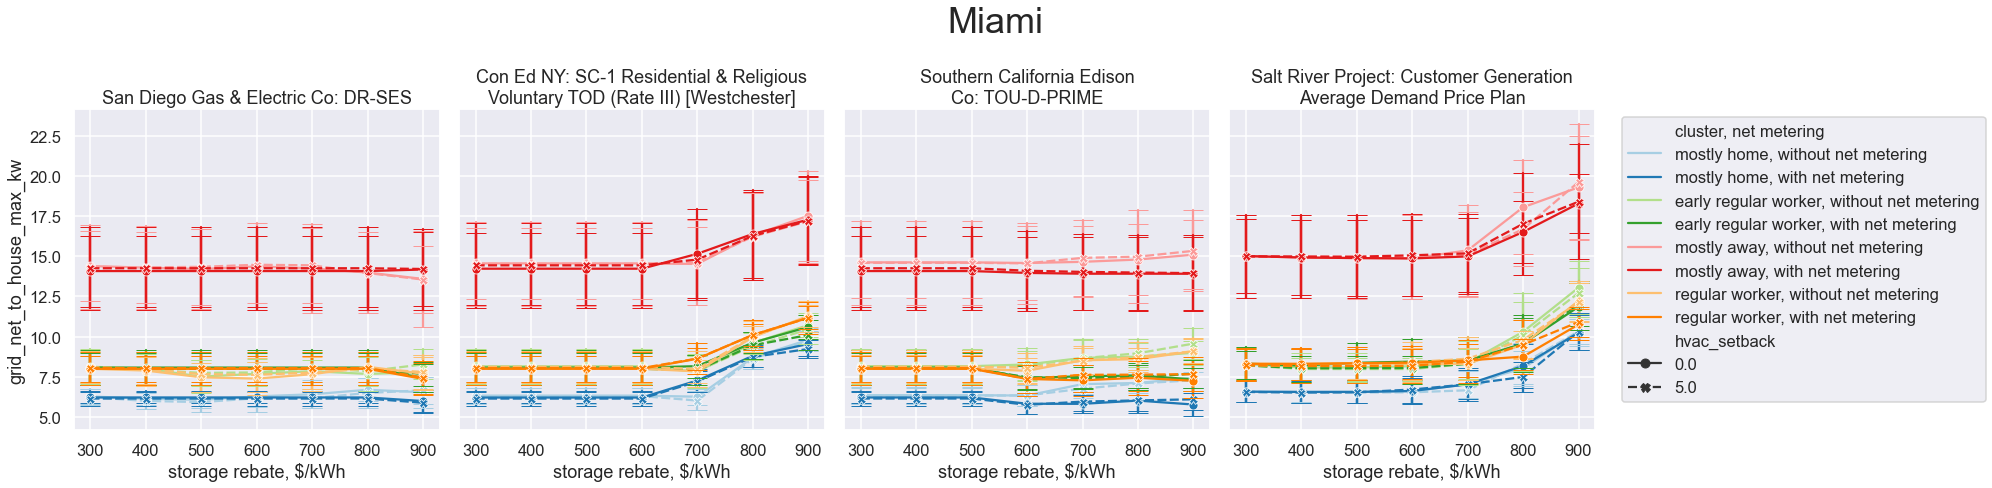

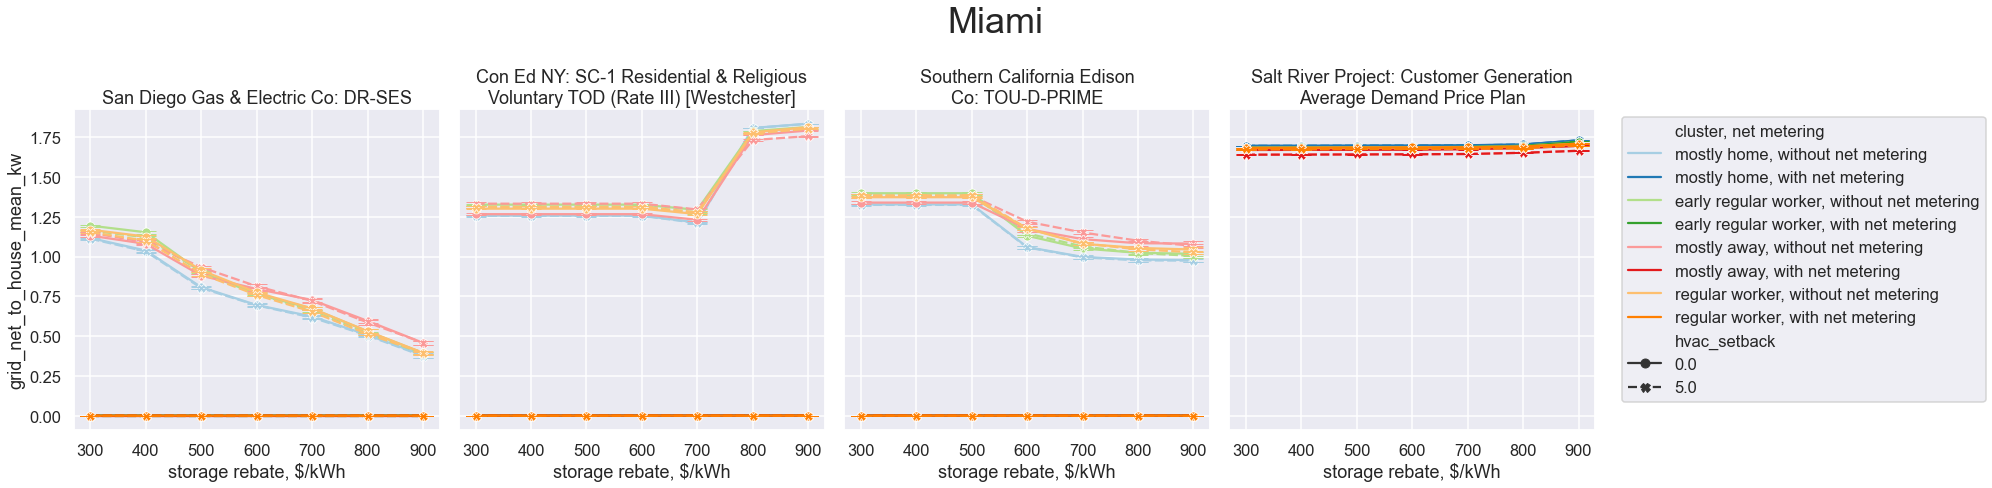

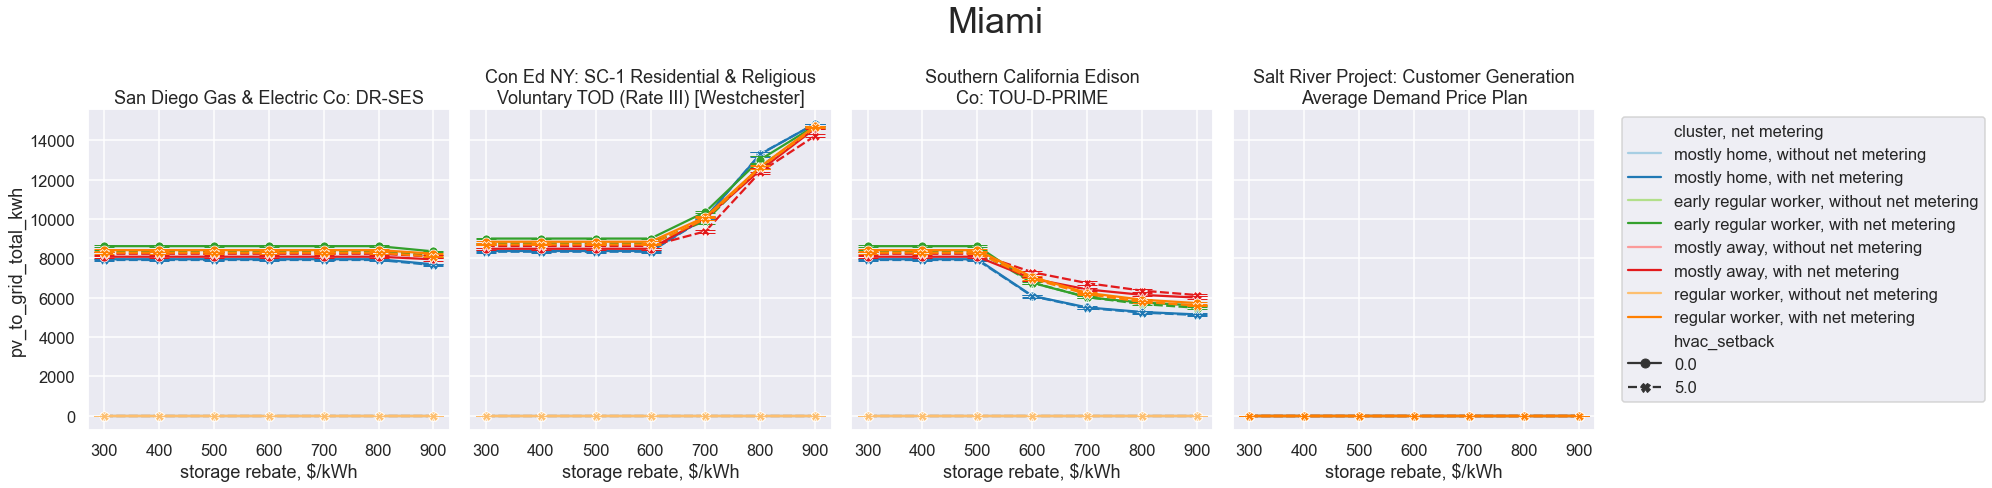

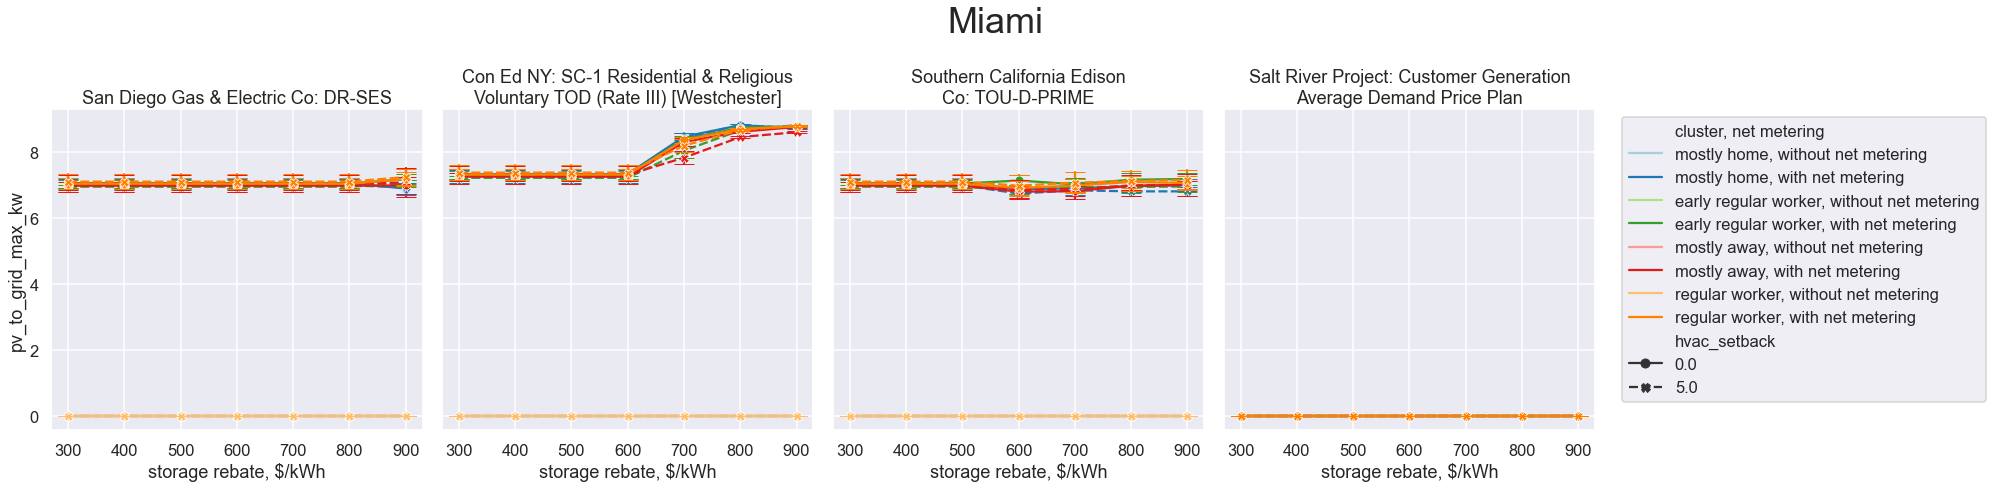

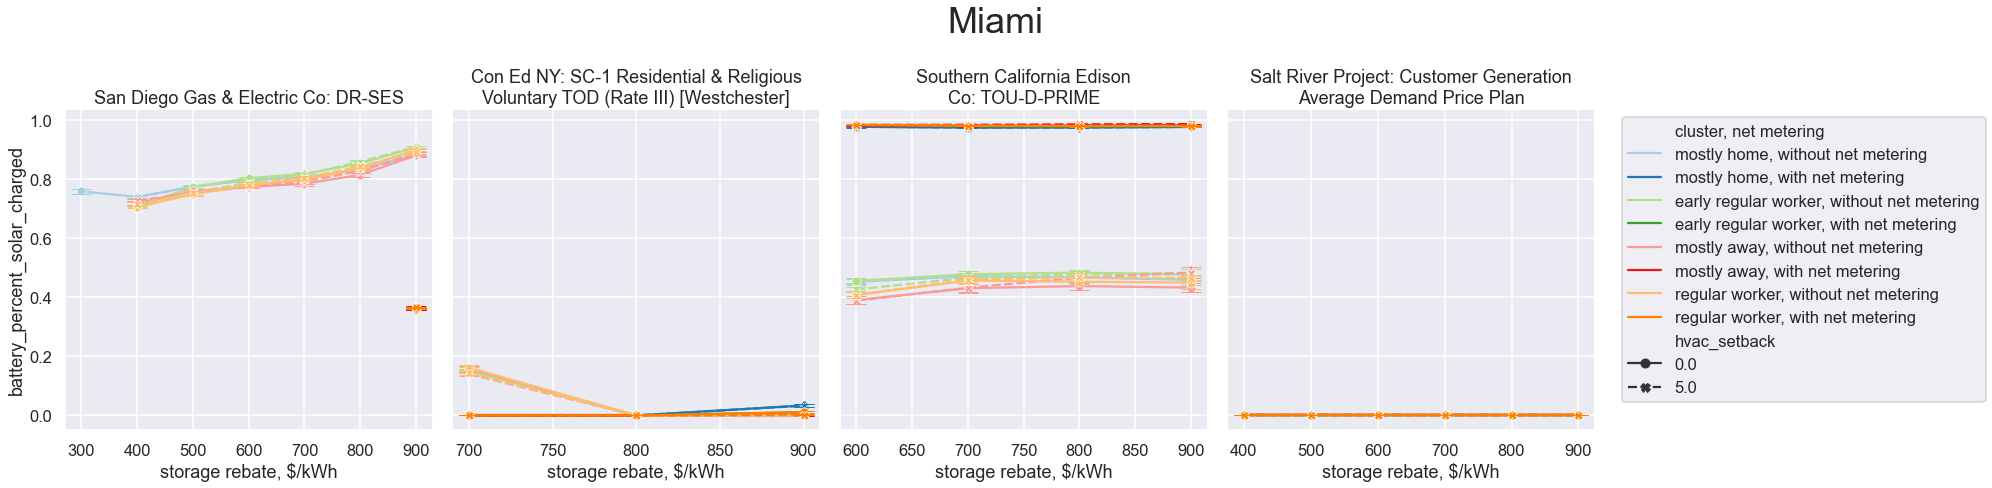

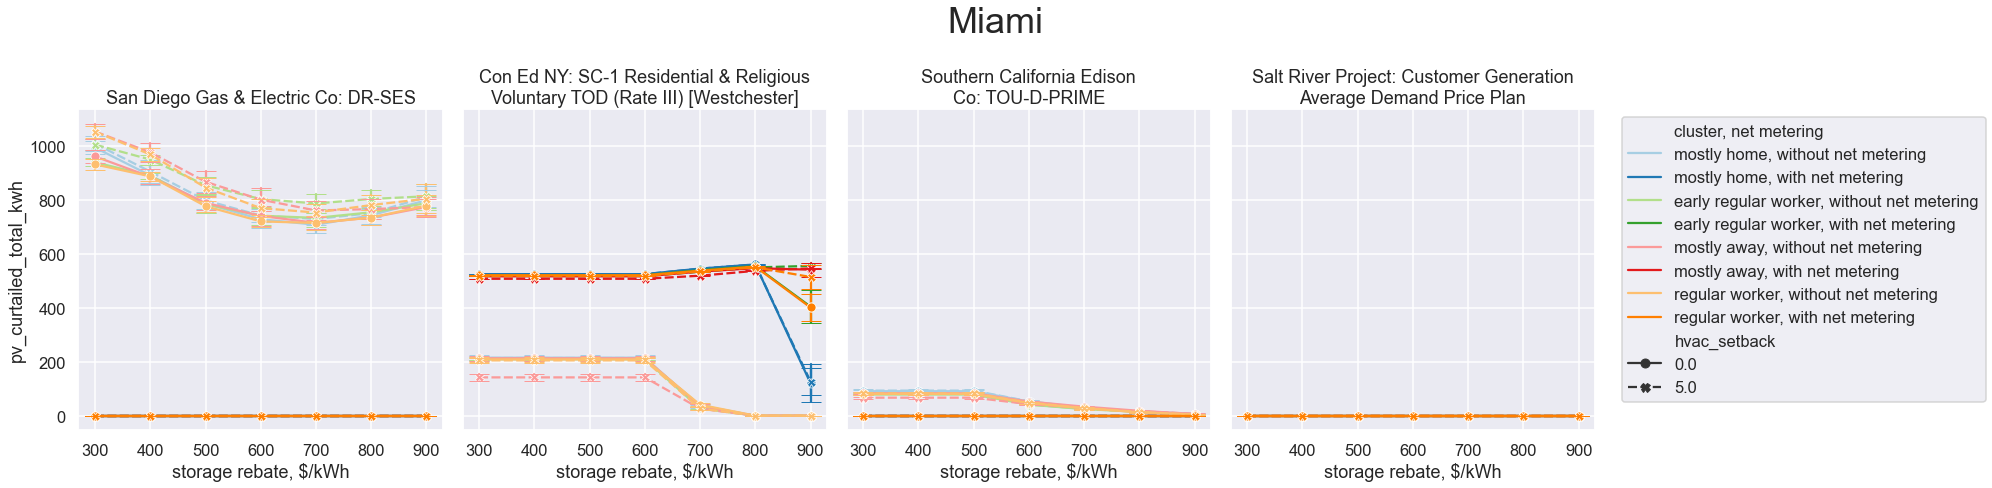

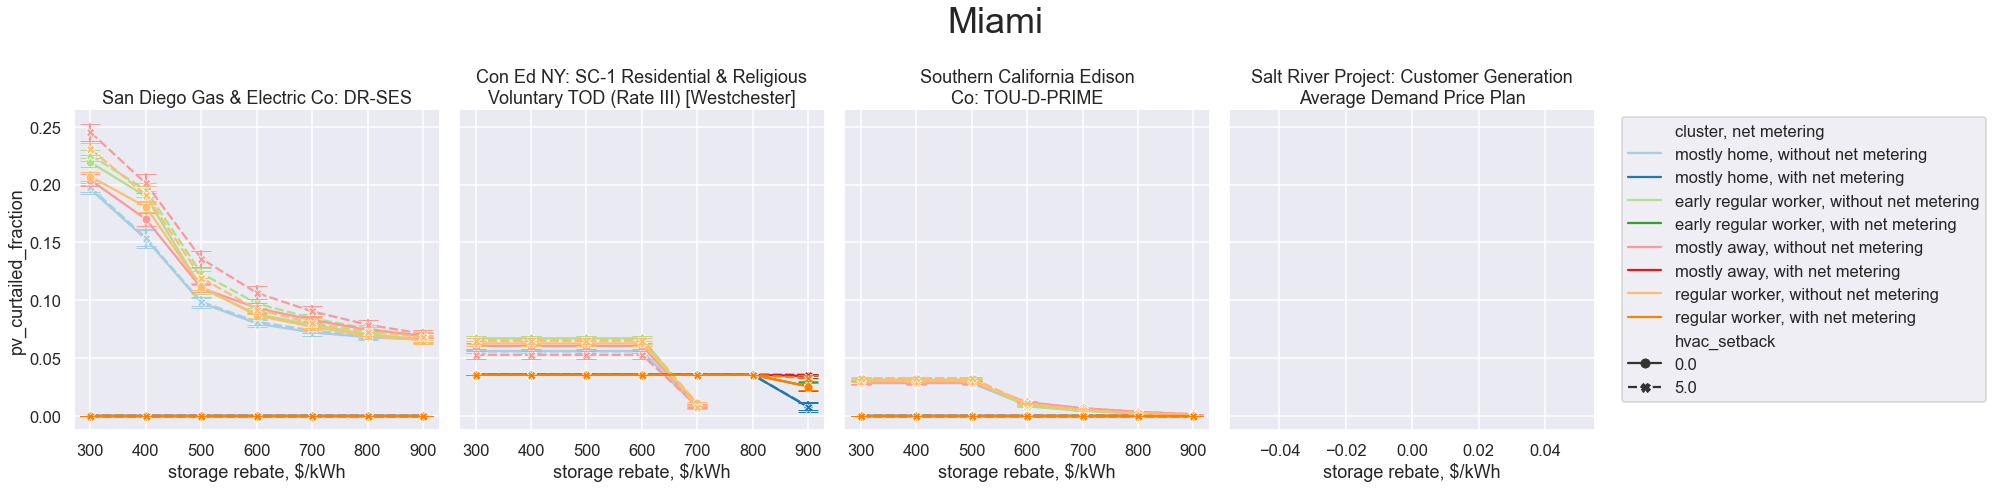

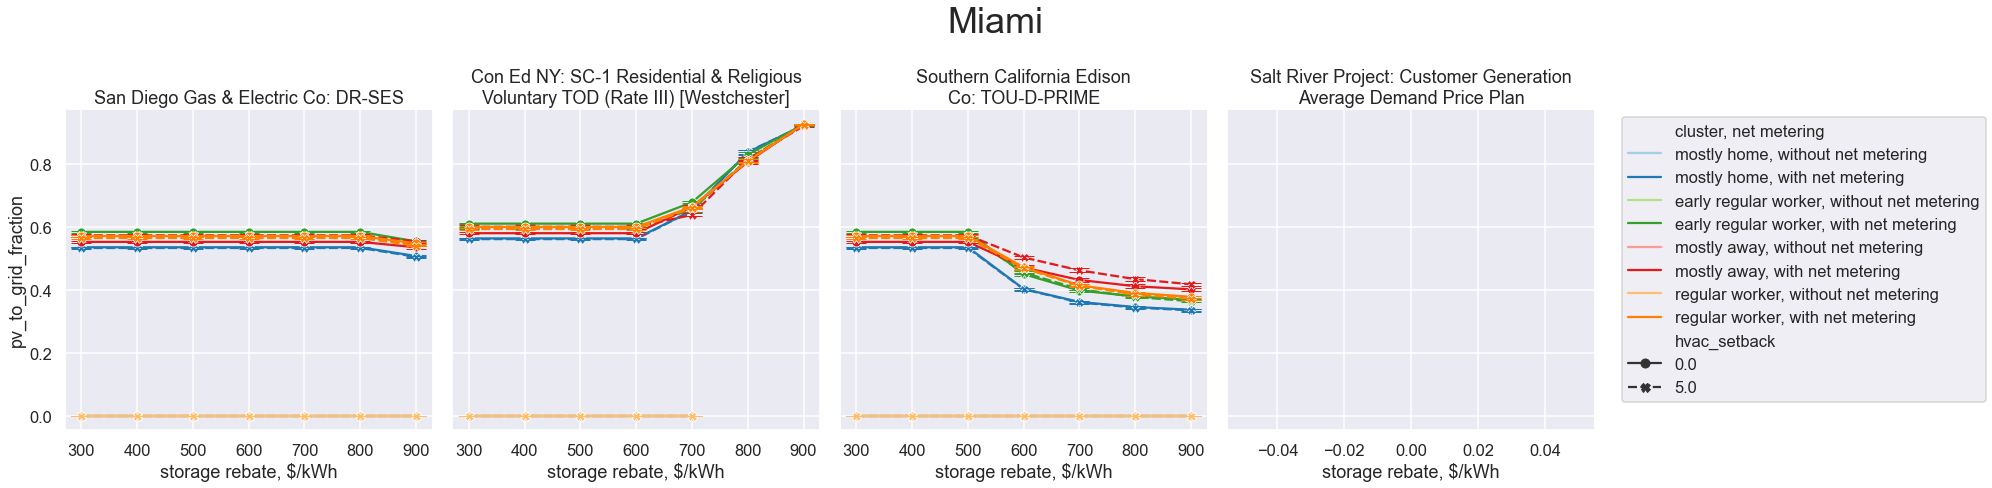

In [276]:
plot_load_stats(load_stats.loc['Miami'], 'Miami',
                columns=[
                        "grid_net_to_house_max_kw",
                        "grid_net_to_house_mean_kw",
                        "pv_to_grid_total_kwh",
                        "pv_to_grid_max_kw",
                        "battery_percent_solar_charged",
                        "pv_curtailed_total_kwh",
                        "pv_curtailed_fraction",
                        "pv_to_grid_fraction"
                    ]
               )

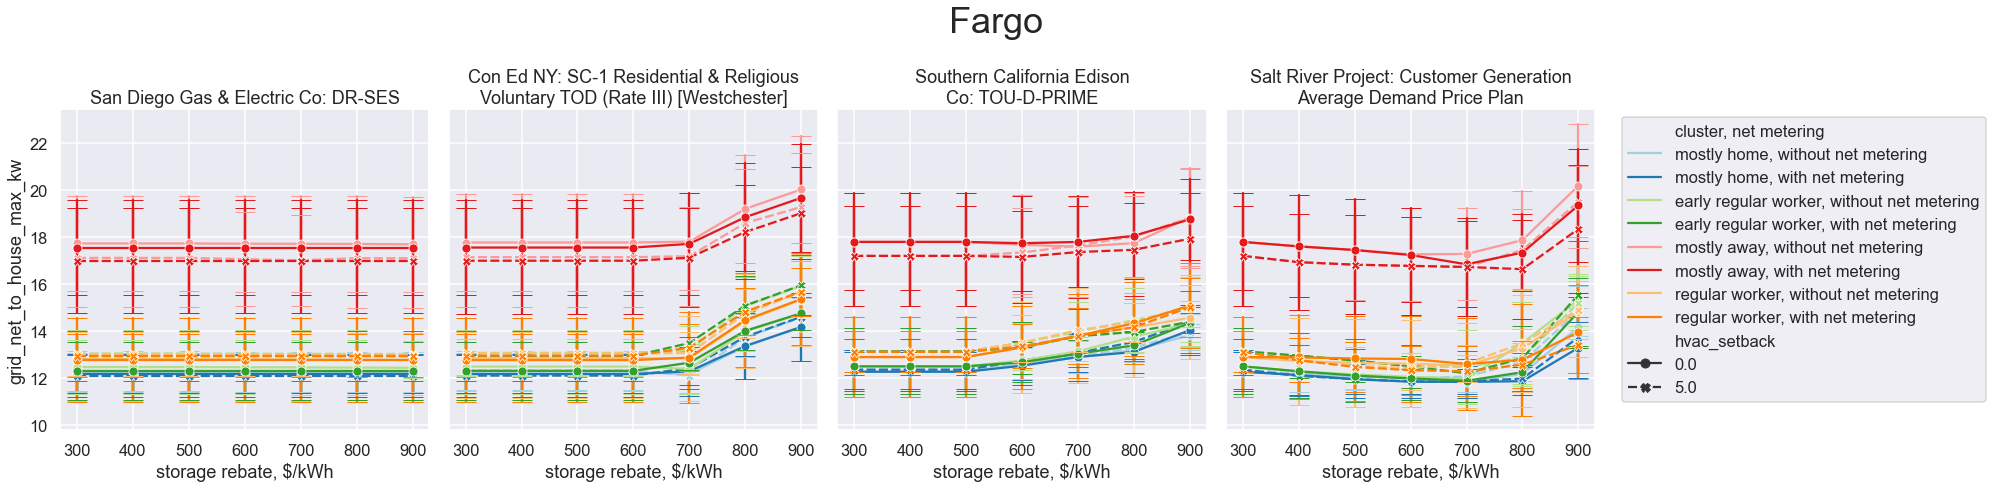

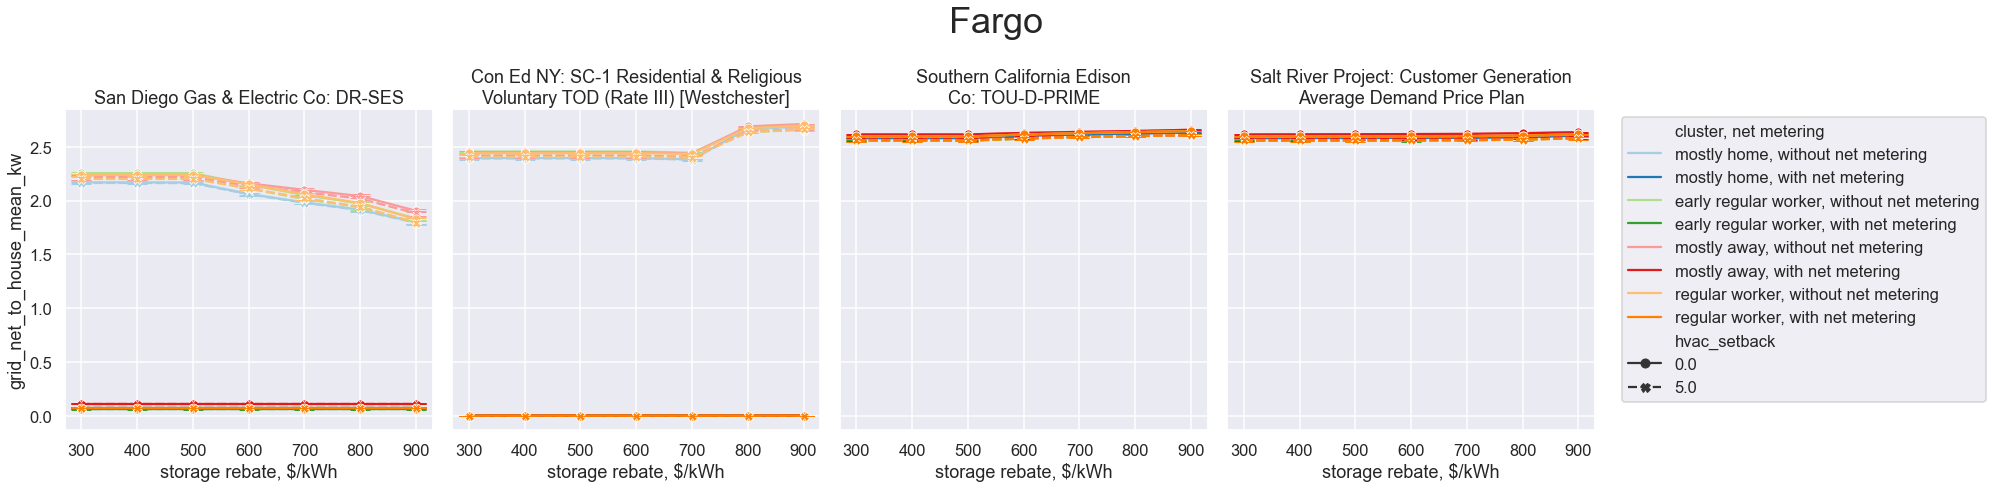

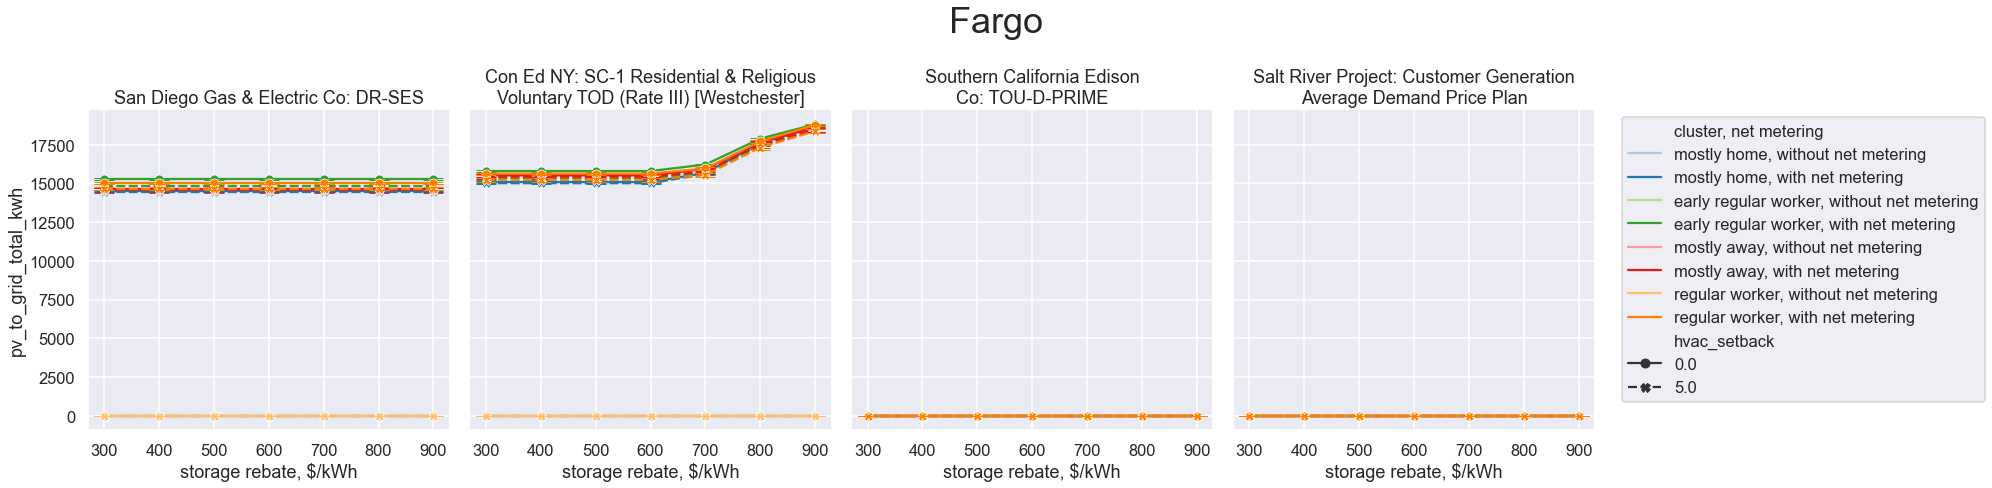

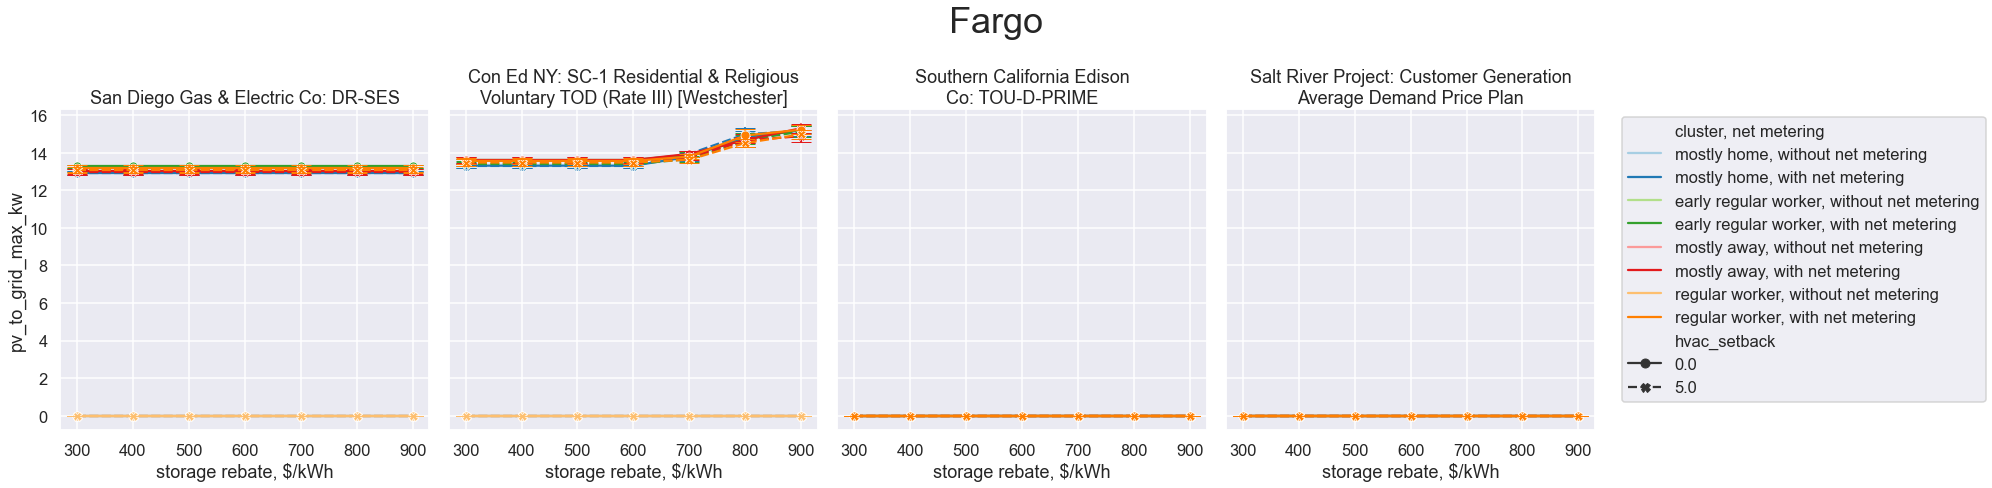

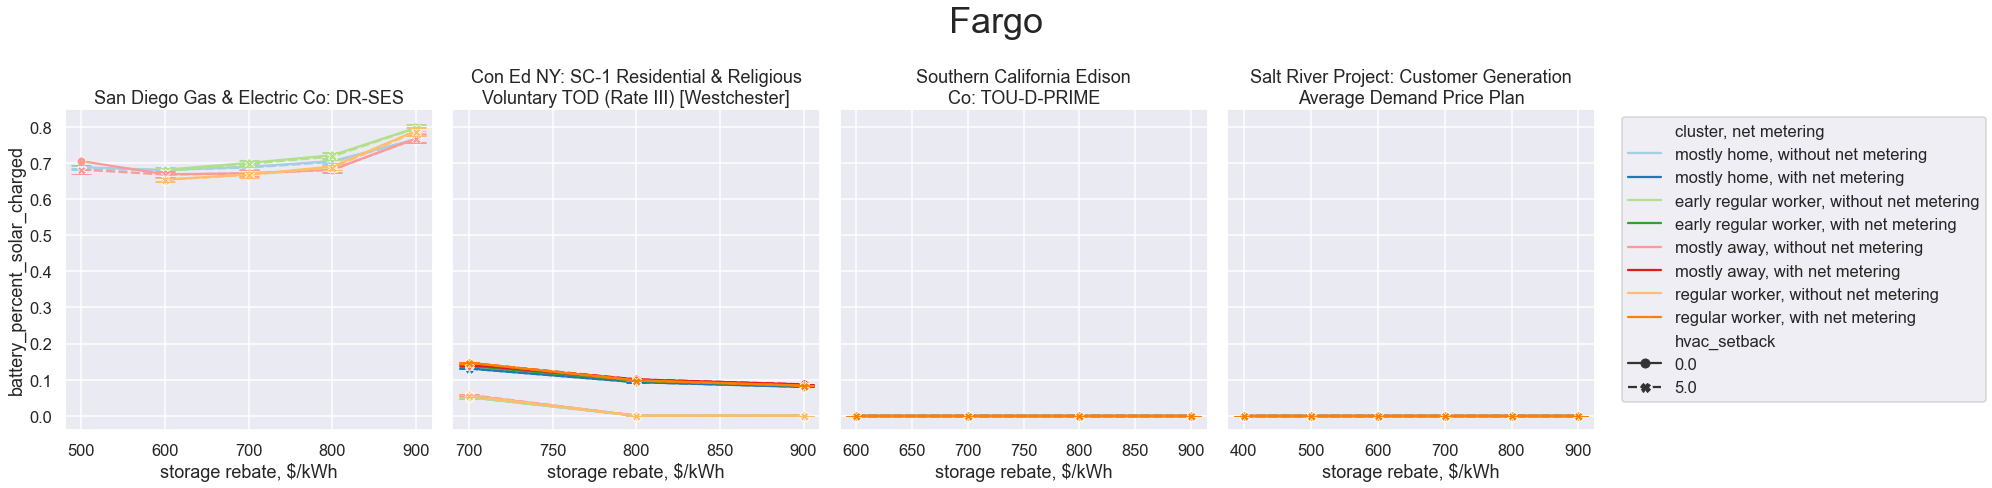

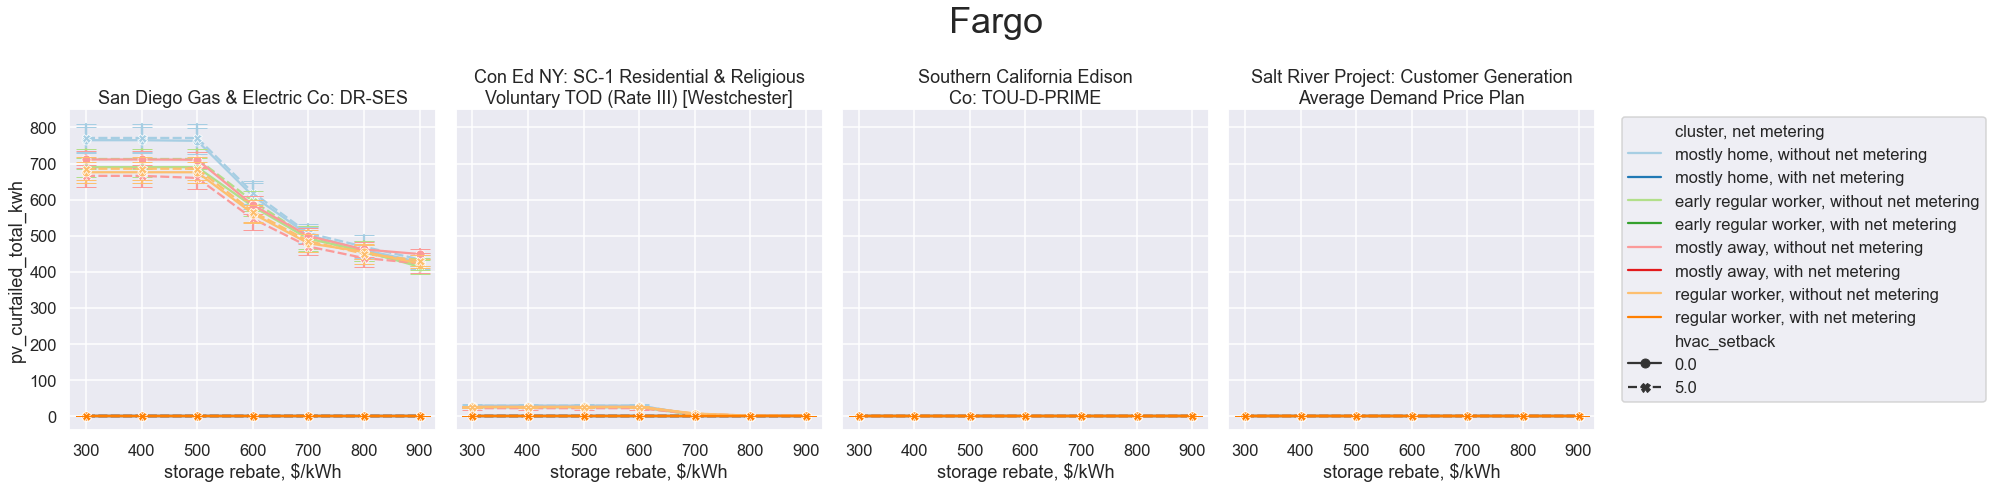

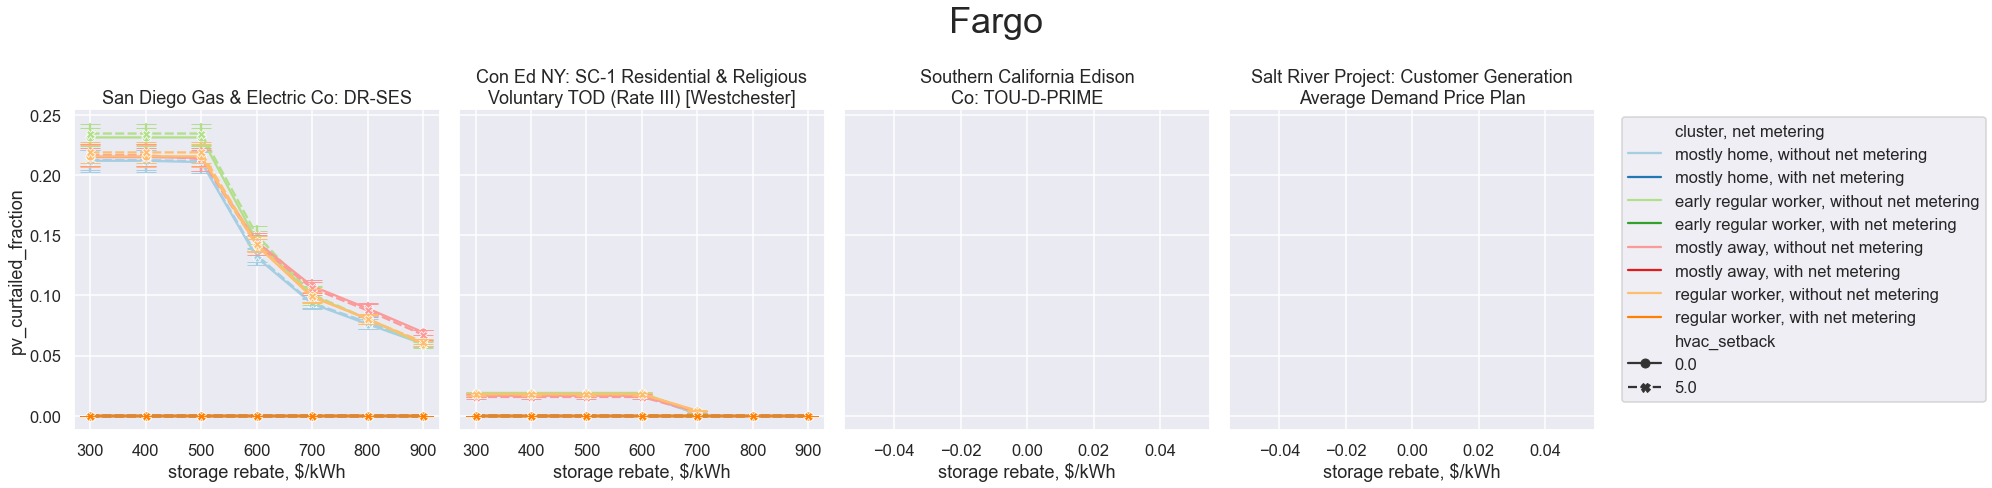

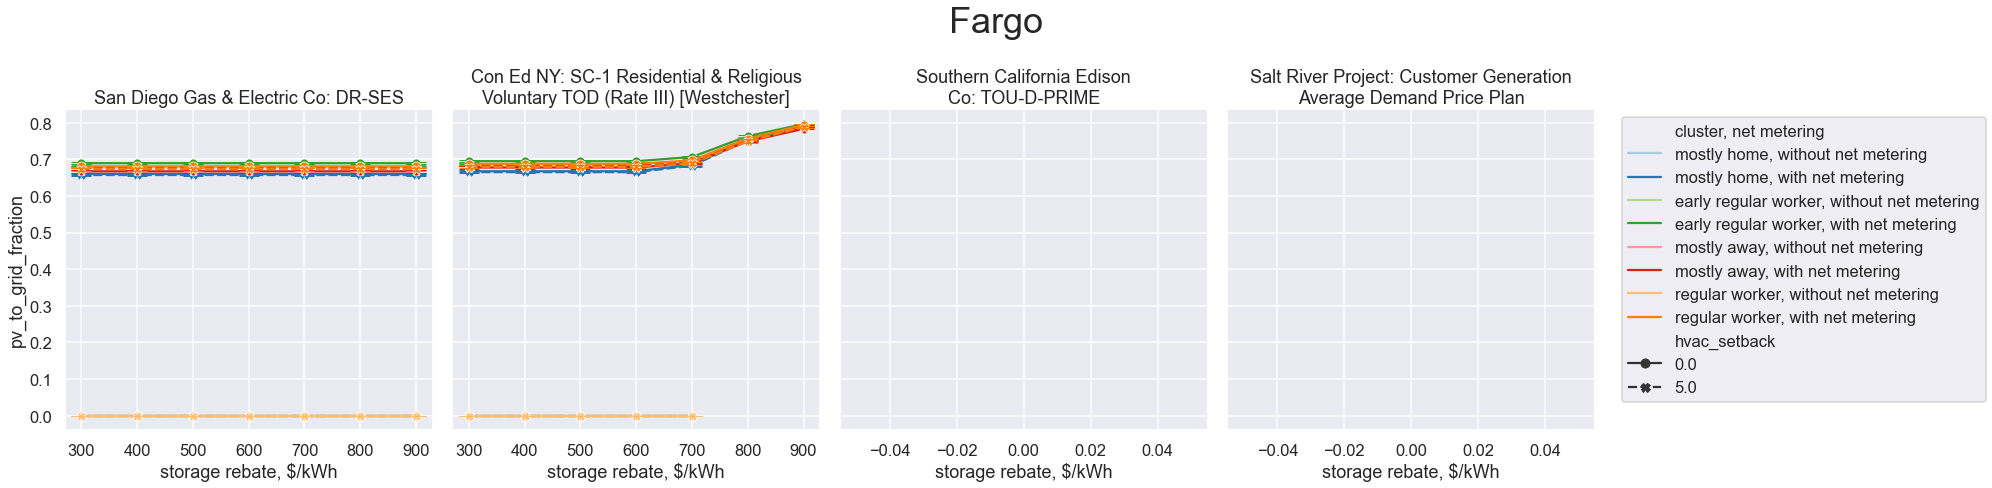

In [277]:
plot_load_stats(load_stats.loc['Fargo'], 'Fargo',
                columns=[
                        "grid_net_to_house_max_kw",
                        "grid_net_to_house_mean_kw",
                        "pv_to_grid_total_kwh",
                        "pv_to_grid_max_kw",
                        "battery_percent_solar_charged",
                        "pv_curtailed_total_kwh",
                        "pv_curtailed_fraction",
                        "pv_to_grid_fraction"
                    ]
                )

In [19]:
import tariff
from importlib import reload
reload(tariff)

<module 'tariff' from '/Users/dshen/Documents/NREL/code/urbanopt-reopt-telework-project/example_project/tariff.py'>

5cafb9ce5457a39d457780e6
5cd1e30b5457a3a52a54e9d3
5d67f2485457a3ab71c68cdd
5dc49b5f5457a39661f6a951


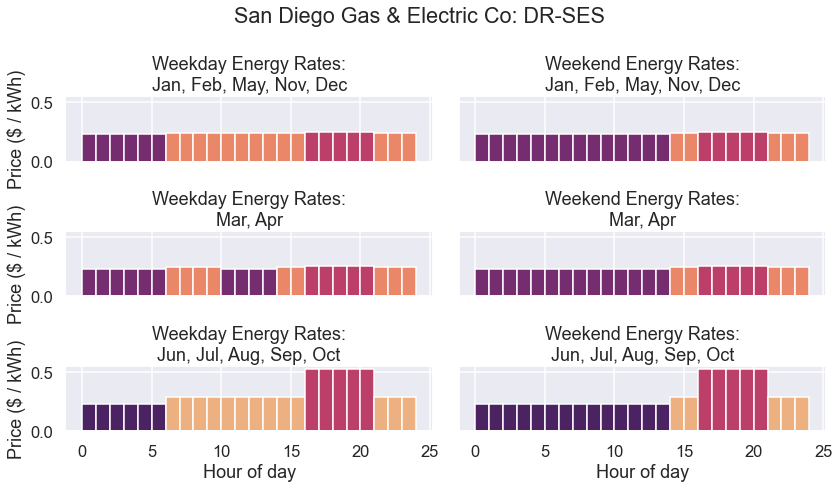

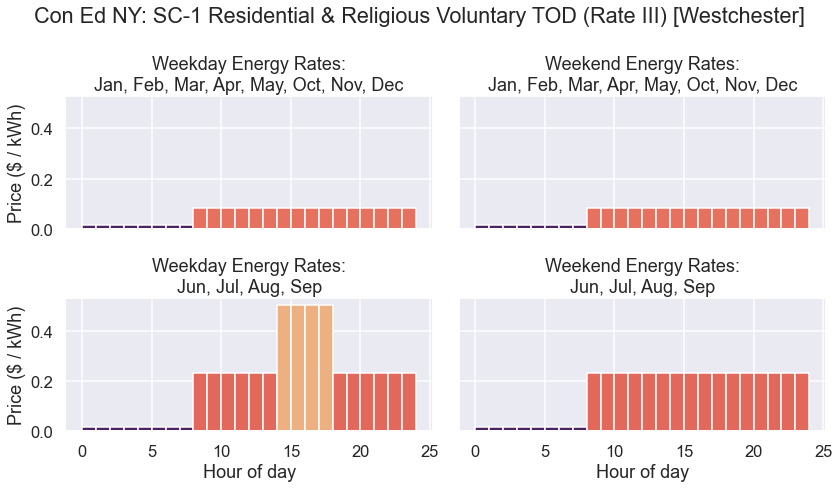

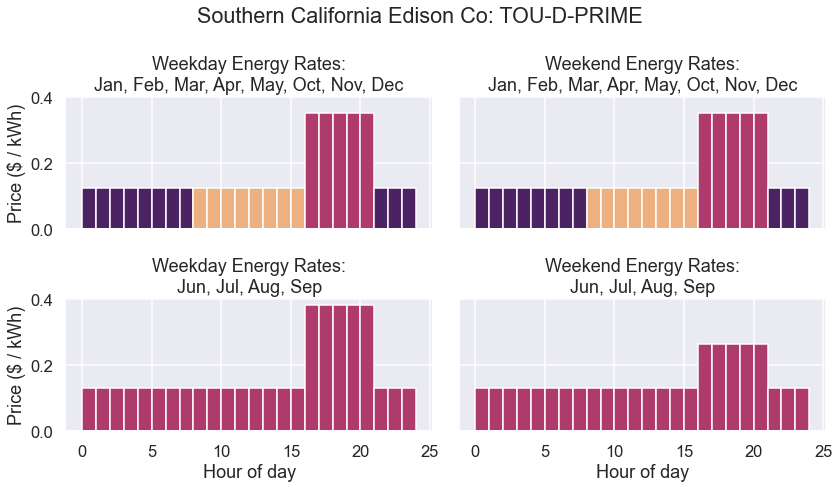

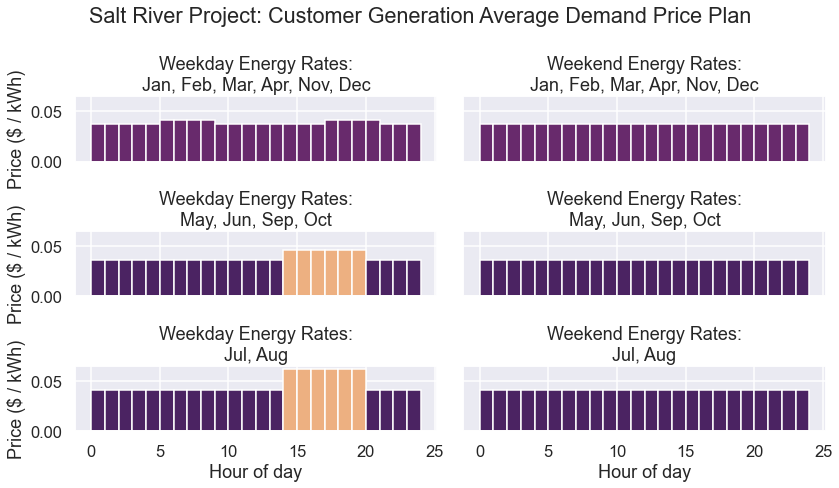

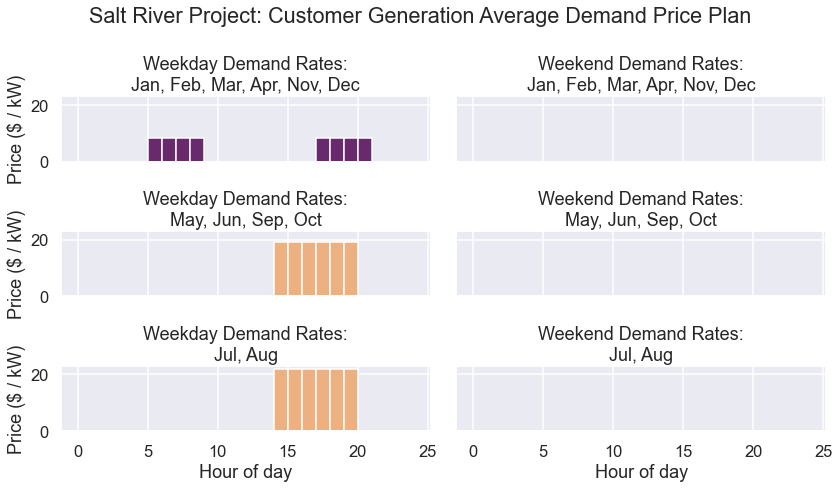

In [42]:
for urdb in reopt_results['urdb'].unique():
    print(urdb)
    rate = tariff.Rate(urdb)
    fig = rate.visualize_energy_rates()
    fig.suptitle(URDB_NAMES.get(urdb))
    fig.tight_layout()
    
    fig = rate.visualize_demand_rates()
    if fig is None:
        continue
    fig.suptitle(URDB_NAMES.get(urdb))
    fig.tight_layout()